In [ ]:
pip install pandas matplotlib seaborn statsmodels scikit-learn

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"

import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
# Carga el dataset
df_orig = pd.read_csv("/content/CSV/avocado.csv")
df_orig

Unnamed: 0        Date  AveragePrice  Total Volume     4046       4225  \
0               0  2015-12-27          1.33      64236.62  1036.74   54454.85   
1               1  2015-12-20          1.35      54876.98   674.28   44638.81   
2               2  2015-12-13          0.93     118220.22   794.70  109149.67   
3               3  2015-12-06          1.08      78992.15  1132.00   71976.41   
4               4  2015-11-29          1.28      51039.60   941.48   43838.39   
...           ...         ...           ...           ...      ...        ...   
18244           7  2018-02-04          1.63      17074.83  2046.96    1529.20   
18245           8  2018-01-28          1.71      13888.04  1191.70    3431.50   
18246           9  2018-01-21          1.87      13766.76  1191.92    2452.79   
18247          10  2018-01-14          1.93      16205.22  1527.63    2981.04   
18248          11  2018-01-07          1.62      17489.58  2894.77    2356.13   

         4770  Total Bags  Small Bags  Large Bags  XLarge Bags          type  \
0       48.16     8696.87     8603.62       93.25          0.0  conventional   
1       58.33     9505.56     9408.07       97.49          0.0  conventional   
2      130.50     8145.35     8042.21      103.14          0.0  conventional   
3       72.58     5811.16     5677.40      133.76          0.0  conventional   
4       75.78     6183.95     5986.26      197.69          0.0  conventional   
...       ...         ...         ...         ...          ...           ...   
18244    0.00    13498.67    13066.82      431.85          0.0       organic   
18245    0.00     9264.84     8940.04      324.80          0.0       organic   
18246  727.94     9394.11     9351.80       42.31          0.0       organic   
18247  727.01    10969.54    10919.54       50.00          0.0       organic   
18248  224.53    12014.15    11988.14       26.01          0.0       organic   

       year            region  
0      2015            Albany  
1      2015            Albany  
2      2015            Albany  
3      2015            Albany  
4      2015            Albany  
...     ...               ...  
18244  2018  WestTexNewMexico  
18245  2018  WestTexNewMexico  
18246  2018  WestTexNewMexico  
18247  2018  WestTexNewMexico  
18248  2018  WestTexNewMexico  

[18249 rows x 14 columns]

In [ ]:
# Copia del dataframe para preservar datos originales
df = df_orig.copy()

In [ ]:
# Convierte 'Date' a tipo datetime
df['Date'] = pd.to_datetime(df['Date'])

#Para poder escoger un número de period que tenga sentido en seasonal_decompose primero vamos a entender qué datos tengo

# Crear las columnas 'año', 'mes' y 'día'
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# Crear una columna 'dia_semana' que tenga el nombre del día de la semana
df['dia_semana'] = df['Date'].dt.day_name()

# Visualizar el resultado
print(df[['Date', 'year', 'Month','dia_semana']].head())

#Ver qué días tengo registros de entrada en mi tabla
df['dia_semana'].unique()

        Date  year  Month dia_semana
0 2015-12-27  2015     12     Sunday
1 2015-12-20  2015     12     Sunday
2 2015-12-13  2015     12     Sunday
3 2015-12-06  2015     12     Sunday
4 2015-11-29  2015     11     Sunday


array(['Sunday'], dtype=object)

In [ ]:
# Step 1: Define the unique regions and manually classify them
region_classification = {
    'Albany': 'City',
    'Atlanta': 'City',
    'BaltimoreWashington': 'Region',
    'Boise': 'City',
    'Boston': 'City',
    'BuffaloRochester': 'Region',
    'California': 'GreaterRegion',
    'Charlotte': 'City',
    'Chicago': 'City',
    'CincinnatiDayton': 'Region',
    'Columbus': 'City',
    'DallasFtWorth': 'Region',
    'Denver': 'City',
    'Detroit': 'City',
    'GrandRapids': 'City',
    'GreatLakes': 'GreaterRegion',
    'HarrisburgScranton': 'Region',
    'HartfordSpringfield': 'Region',
    'Houston': 'City',
    'Indianapolis': 'City',
    'Jacksonville': 'City',
    'LasVegas': 'City',
    'LosAngeles': 'City',
    'Louisville': 'City',
    'MiamiFtLauderdale': 'Region',
    'Midsouth': 'GreaterRegion',
    'Nashville': 'City',
    'NewOrleansMobile': 'Region',
    'NewYork': 'City',
    'Northeast': 'GreaterRegion',
    'NorthernNewEngland': 'Region',
    'Orlando': 'City',
    'Philadelphia': 'City',
    'PhoenixTucson': 'Region',
    'Pittsburgh': 'City',
    'Plains': 'GreaterRegion',
    'Portland': 'City',
    'RaleighGreensboro': 'Region',
    'RichmondNorfolk': 'Region',
    'Roanoke': 'City',
    'Sacramento': 'City',
    'SanDiego': 'City',
    'SanFrancisco': 'City',
    'Seattle': 'City',
    'SouthCarolina': 'State',
    'SouthCentral': 'GreaterRegion',
    'Southeast': 'GreaterRegion',
    'Spokane': 'City',
    'StLouis': 'City',
    'Syracuse': 'City',
    'Tampa': 'City',
    'TotalUS': 'TotalUS',
    'West': 'GreaterRegion',
    'WestTexNewMexico': 'Region'
}
def get_regions(name):
  cat_region = region_classification.get(name)
  return cat_region

In [ ]:
# Añade columna con categorización de City/Region/GreaterRegion/TotalUS
df['region_type'] = df['region'].transform(lambda x: get_regions(x))

In [ ]:
# Prepara filtro de filas para tener en cuenta sólo verdaderamente GreaterRegion
greater_regions = df[df['region_type'].isin(['GreaterRegion'])]
greater_regions

Unnamed: 0        Date  AveragePrice  Total Volume        4046  \
312             0  2015-12-27          0.90    5040365.47  1833946.59   
313             1  2015-12-20          0.94    4695737.21  1676601.43   
314             2  2015-12-13          0.87    5259354.30  1806690.08   
315             3  2015-12-06          0.78    5775536.27  1943065.50   
316             4  2015-11-29          0.91    4575710.62  1461699.38   
...           ...         ...           ...           ...         ...   
18232           7  2018-02-04          1.41     283378.47    22474.66   
18233           8  2018-01-28          1.80     185974.53    22918.40   
18234           9  2018-01-21          1.83     189317.99    27049.44   
18235          10  2018-01-14          1.82     207999.67    33869.12   
18236          11  2018-01-07          1.48     297190.60    34734.97   

             4225       4770  Total Bags  Small Bags  Large Bags  XLarge Bags  \
312    1760956.02  232755.85  1212707.01  1090140.07   110737.35     11829.59   
313    1543280.76  266689.82  1209165.20  1061703.58   136747.10     10714.52   
314    1627240.76  232985.13  1592438.33  1404012.00   180150.37      8275.96   
315    2100246.17  221957.26  1510267.34  1376640.91   126664.37      6962.06   
316    1810202.70  222311.07  1081497.47   991568.84    82338.39      7590.24   
...           ...        ...         ...         ...         ...          ...   
18232    55360.49     133.41   205409.91    70232.59   134666.91       510.41   
18233    33051.14      93.52   129911.47    77822.23    51986.86       102.38   
18234    33561.32     439.47   128267.76    76091.99    51947.50       228.27   
18235    47435.14     433.52   126261.89    89115.78    37133.99        12.12   
18236    62967.74     157.77   199330.12   103761.55    95544.39        24.18   

               type  year      region    region_type  
312    conventional  2015  California  GreaterRegion  
313    conventional  2015  California  GreaterRegion  
314    conventional  2015  California  GreaterRegion  
315    conventional  2015  California  GreaterRegion  
316    conventional  2015  California  GreaterRegion  
...             ...   ...         ...            ...  
18232       organic  2018        West  GreaterRegion  
18233       organic  2018        West  GreaterRegion  
18234       organic  2018        West  GreaterRegion  
18235       organic  2018        West  GreaterRegion  
18236       organic  2018        West  GreaterRegion  

[2704 rows x 15 columns]

# **5**

# 5.1 Análisis de Correlación y Regresión


Este apartado, se centra en la identificación de relaciones significativas entre las variables numéricas y el desarrollo de modelos de regresión para hacer predicciones basadas en esas relaciones.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np

df_filtered = pd.read_csv('/content/CSV/avocado.csv')

df = df_filtered.copy()
# Añade columna con categorización de City/Region/GreaterRegion/TotalUS
df['region_type'] = df['region'].transform(lambda x: get_regions(x))

# Convert 'Date' to datetime if not already done
df['Date'] = pd.to_datetime(df['Date'])
df=df.sort_values(by='Date')
#df_filtered= df_filtered[df_filtered['region']=='West']
#df_filtered= df_filtered[df_filtered['AveragePrice']>1.1]

# Filtrar los datos para 'GreaterRegion' en la columna 'region_type'
df_reduced = df.loc[df['region_type'] == 'GreaterRegion'].copy()
df_cities = df.loc[df['region_type'] == 'City'].copy()
df_regions = df.loc[df['region_type'] == 'Region'].copy()

df

Unnamed: 0       Date  AveragePrice  Total Volume        4046  \
11569          51 2015-01-04          1.75      27365.89     9307.34   
9593           51 2015-01-04          1.49      17723.17     1189.35   
10009          51 2015-01-04          1.68       2896.72      161.68   
1819           51 2015-01-04          1.52      54956.80     3013.04   
9333           51 2015-01-04          1.64       1505.12        1.27   
...           ...        ...           ...           ...         ...   
8574            0 2018-03-25          1.36     908202.13   142681.06   
9018            0 2018-03-25          0.70    9010588.32  3999735.71   
18141           0 2018-03-25          1.42     163496.70    29253.30   
17673           0 2018-03-25          1.70     190257.38    29644.09   
8814            0 2018-03-25          1.34    1774776.77    63905.98   

            4225       4770  Total Bags  Small Bags  Large Bags  XLarge Bags  \
11569    3844.81     615.28    13598.46    13061.10      537.36         0.00   
9593    15628.27       0.00      905.55      905.55        0.00         0.00   
10009     206.96       0.00     2528.08     2528.08        0.00         0.00   
1819    35456.88    1561.70    14925.18    11264.80     3660.38         0.00   
9333     1129.50       0.00      374.35      186.67      187.68         0.00   
...          ...        ...         ...         ...         ...          ...   
8574   463136.28  174975.75   127409.04   103579.41    22467.04      1362.59   
9018   966589.50   30130.82  4014132.29  3398569.92   546409.74     69152.63   
18141    5080.04       0.00   129163.36   109052.26    20111.10         0.00   
17673   70982.10       0.00    89631.19    89424.11      207.08         0.00   
8814   908653.71     843.45   801373.63   774634.09    23833.93      2905.61   

               type  year              region    region_type  
11569       organic  2015           Southeast  GreaterRegion  
9593        organic  2015             Chicago           City  
10009       organic  2015  HarrisburgScranton         Region  
1819   conventional  2015          Pittsburgh           City  
9333        organic  2015               Boise           City  
...             ...   ...                 ...            ...  
8574   conventional  2018             Chicago           City  
9018   conventional  2018        SouthCentral  GreaterRegion  
18141       organic  2018        SouthCentral  GreaterRegion  
17673       organic  2018          California  GreaterRegion  
8814   conventional  2018             NewYork           City  

[18249 rows x 15 columns]

Implementar el grafico

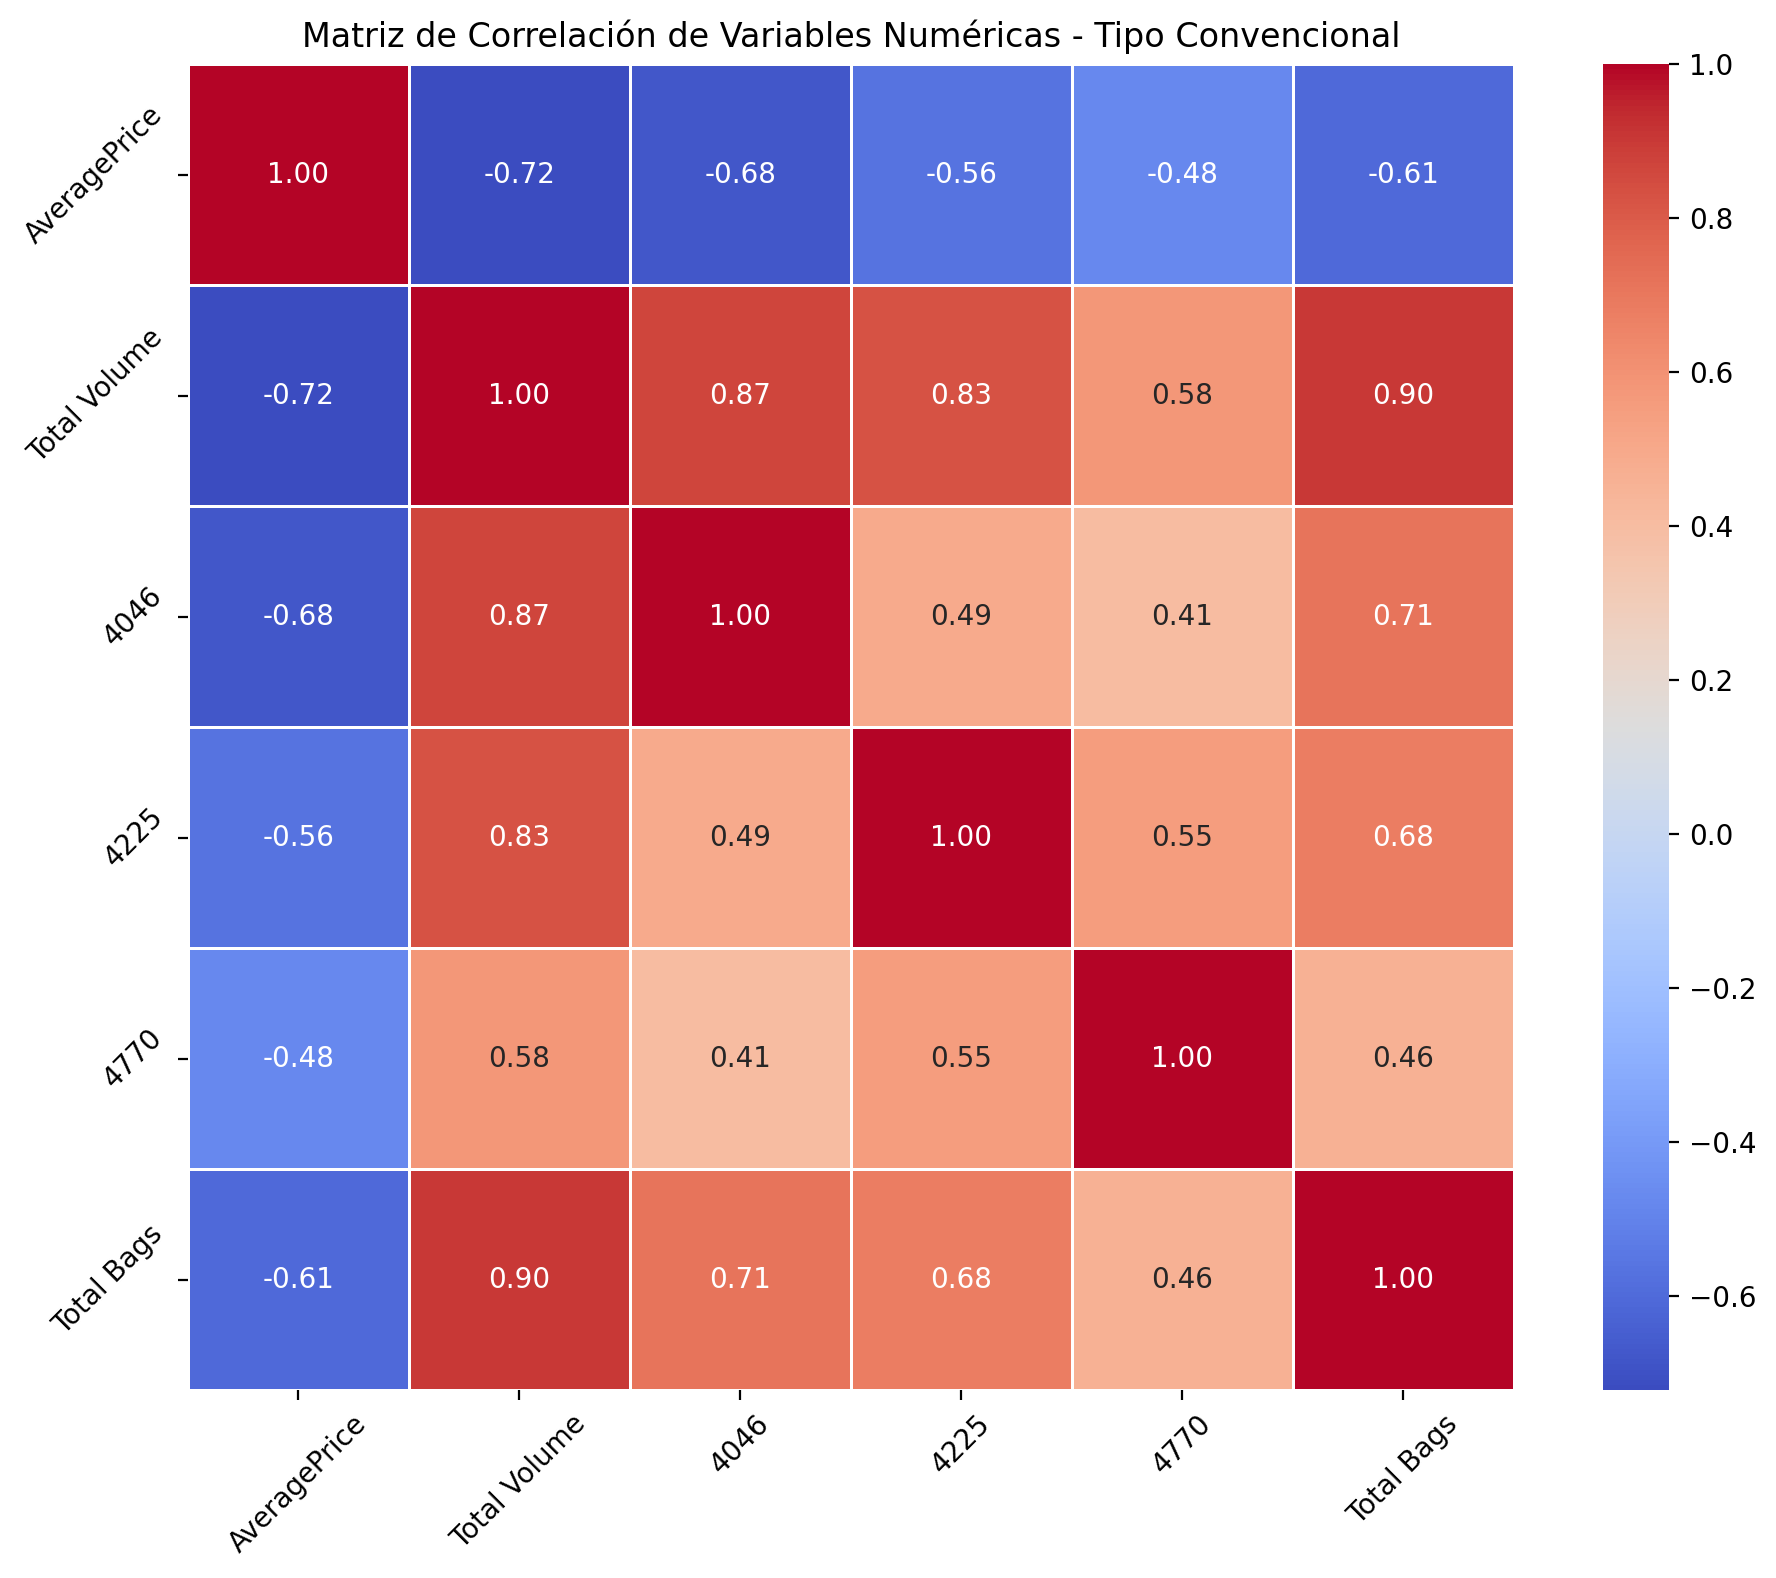

In [ ]:
# Filter data for conventional type only
df_mat = greater_regions[['AveragePrice', 'Total Volume', '4046', '4225', '4770', 'Total Bags']].corr()
# Configure the visualization
plt.figure(figsize=(10, 8))
sns.heatmap(df_mat, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=0.5)

# Customize the plot
plt.title('Matriz de Correlación de Variables Numéricas - Tipo Convencional')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

Hemos implementado como apartado "Total Bags" puesto que este es la combinación de Small Bags, Large Bags i XLarge Bags, así que sacamos esas tres y dejamos solo ese apartado.

# 5.2. Análisis de Dispersión entre Variables Clave:


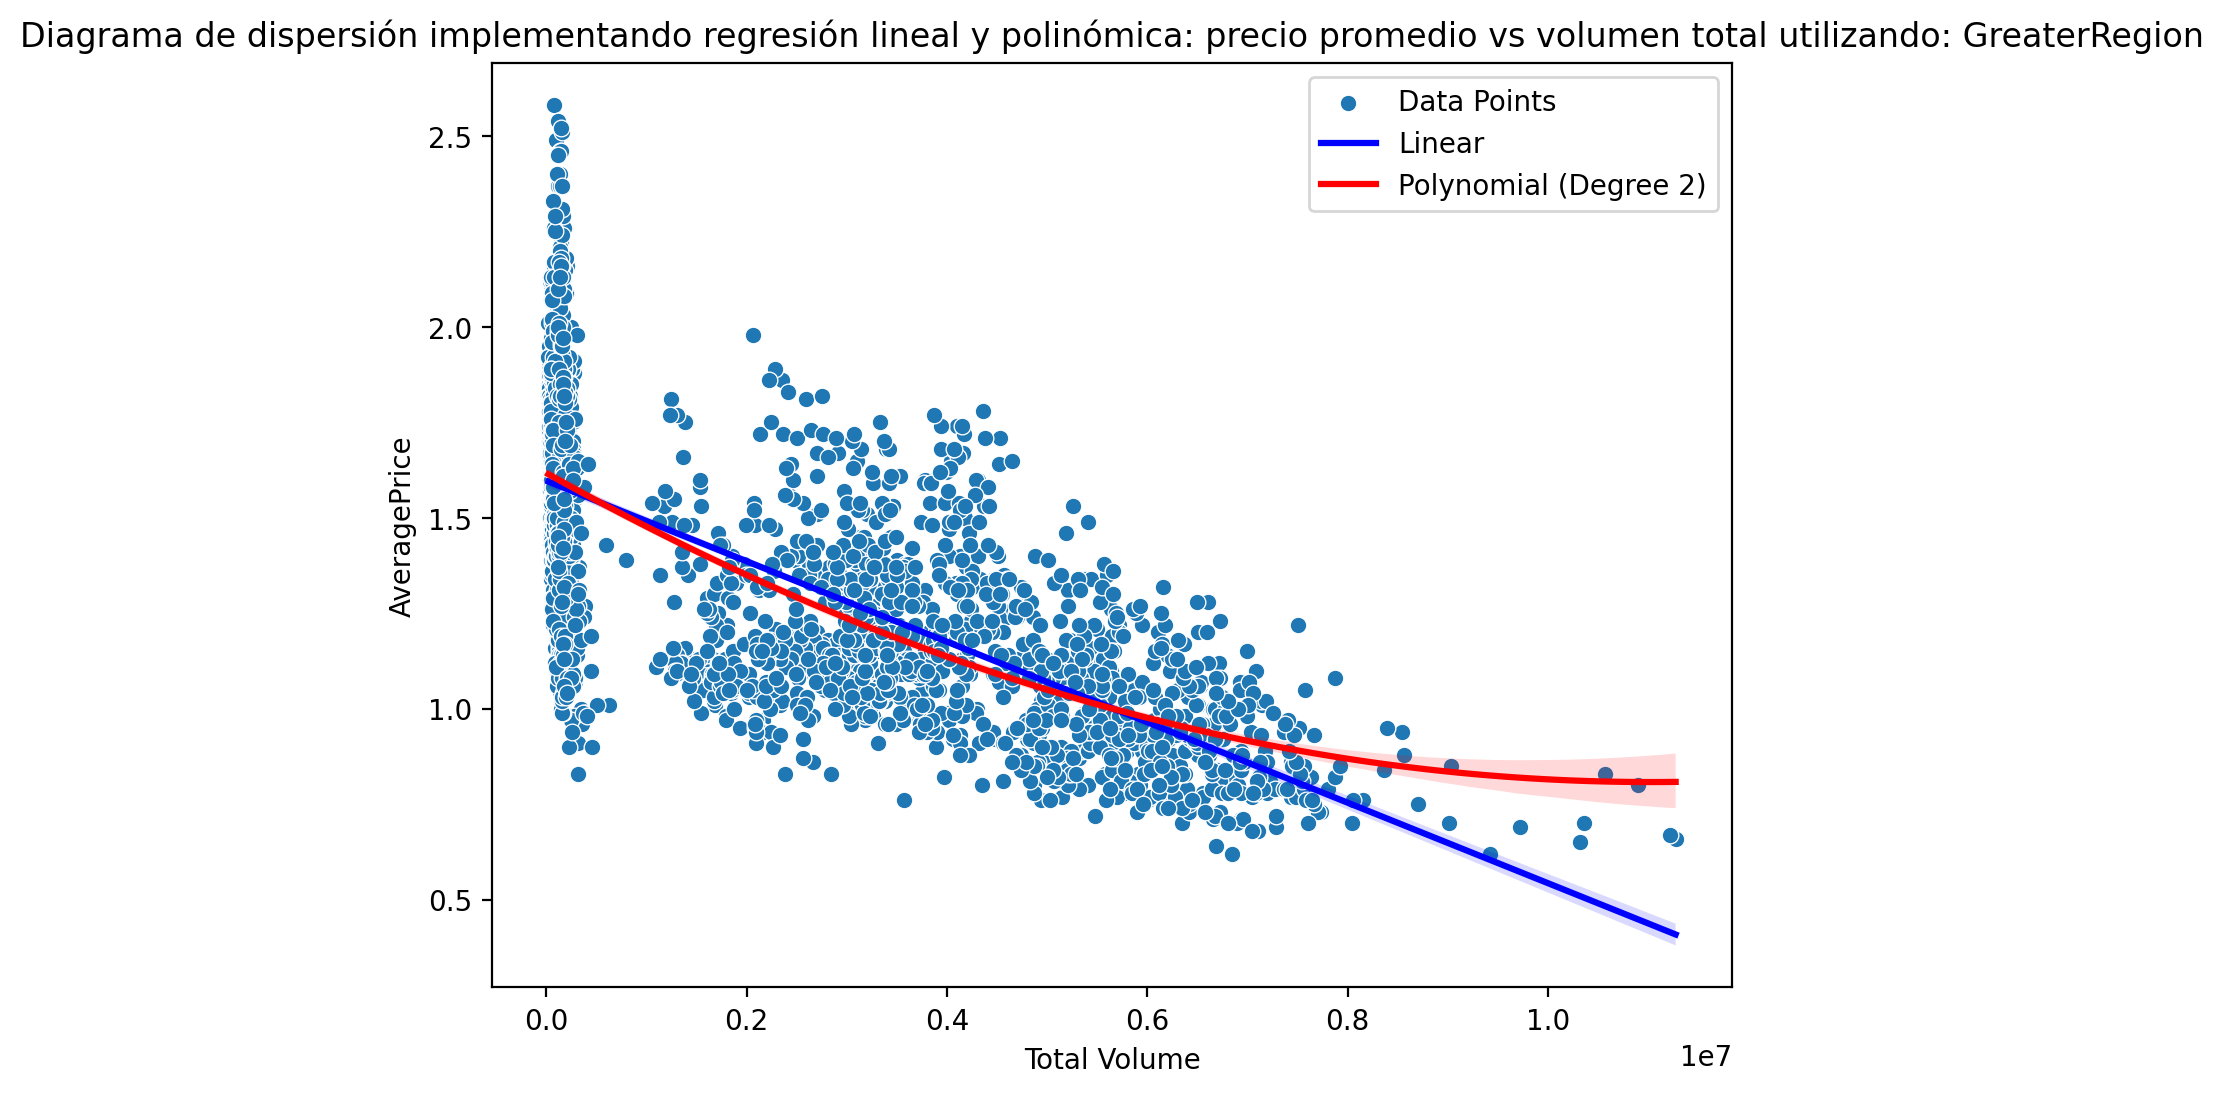

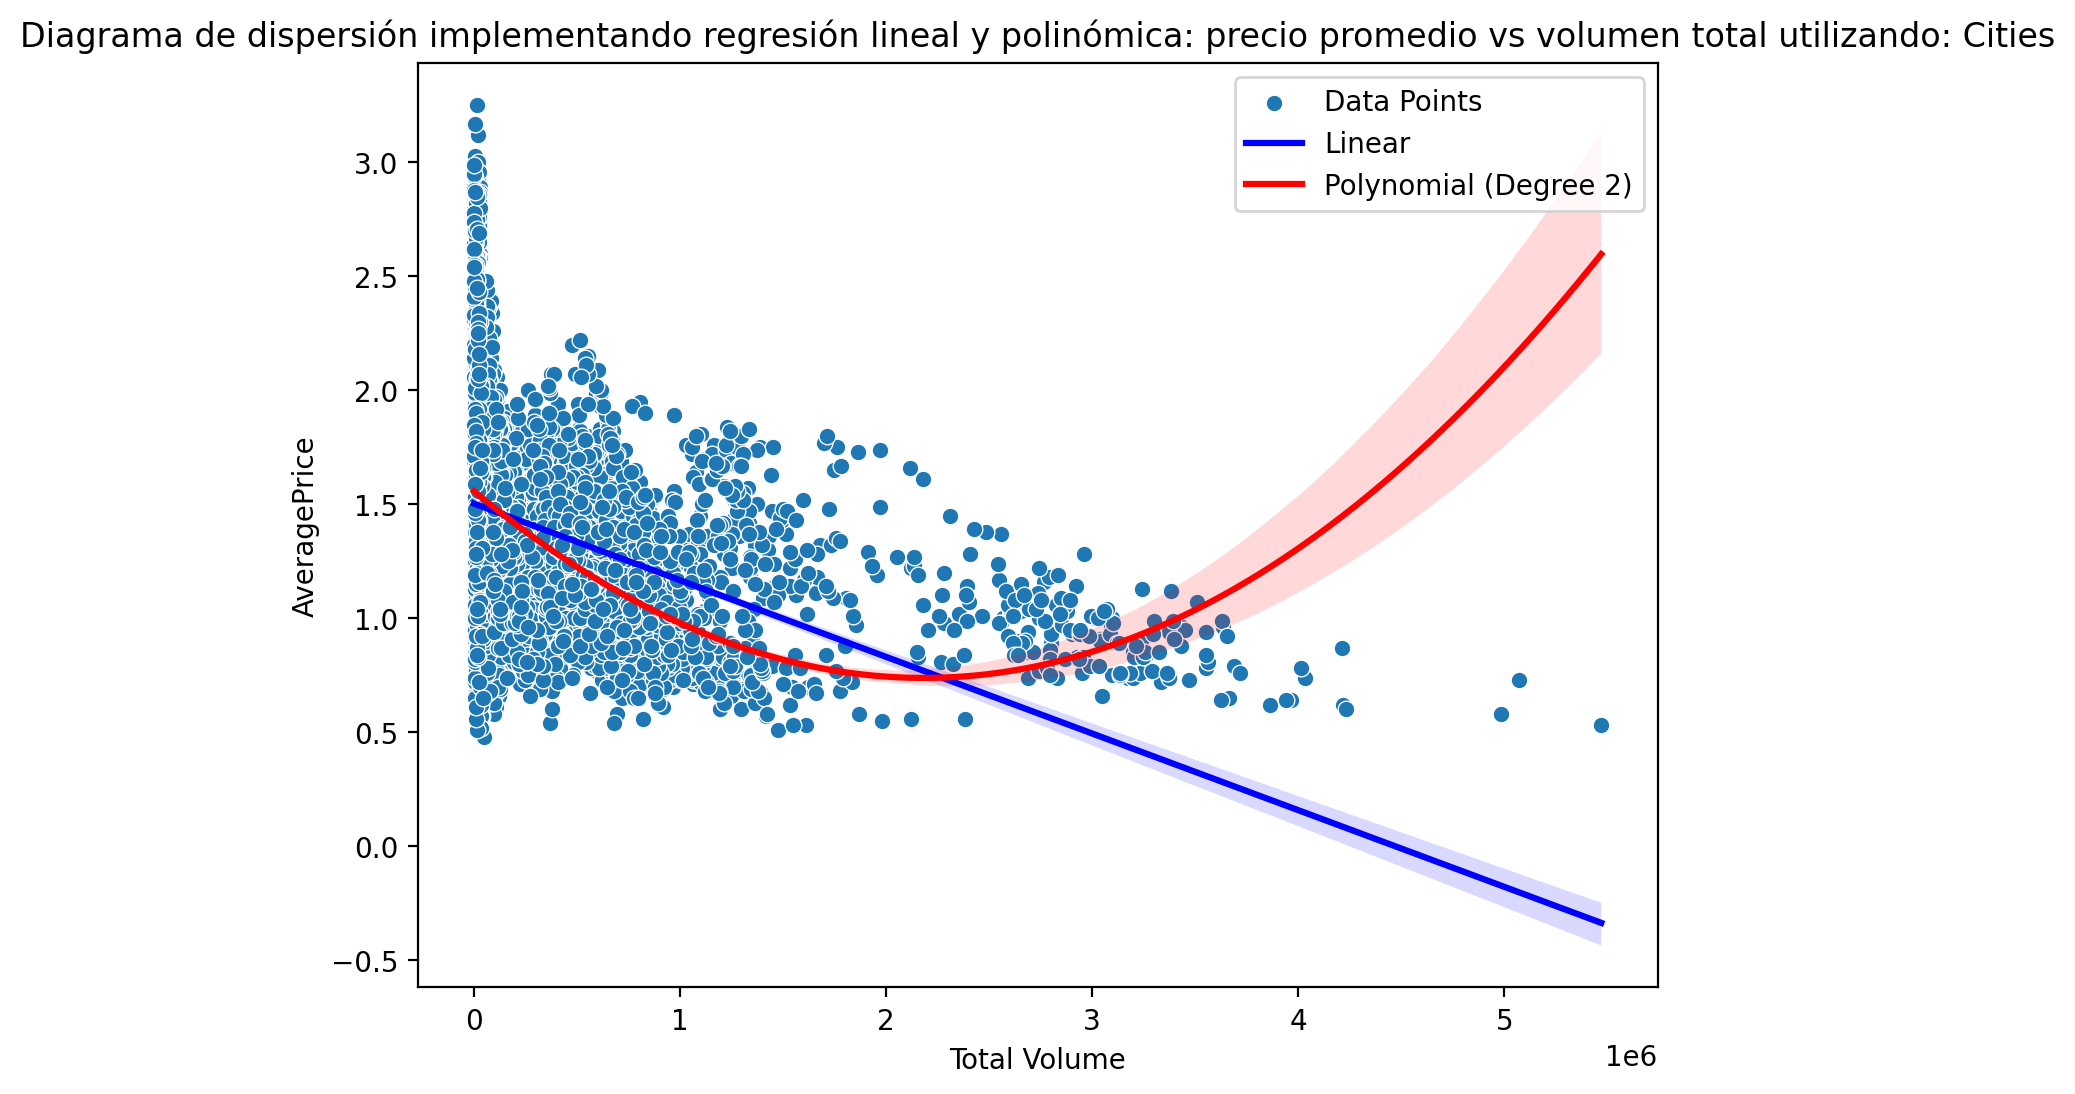

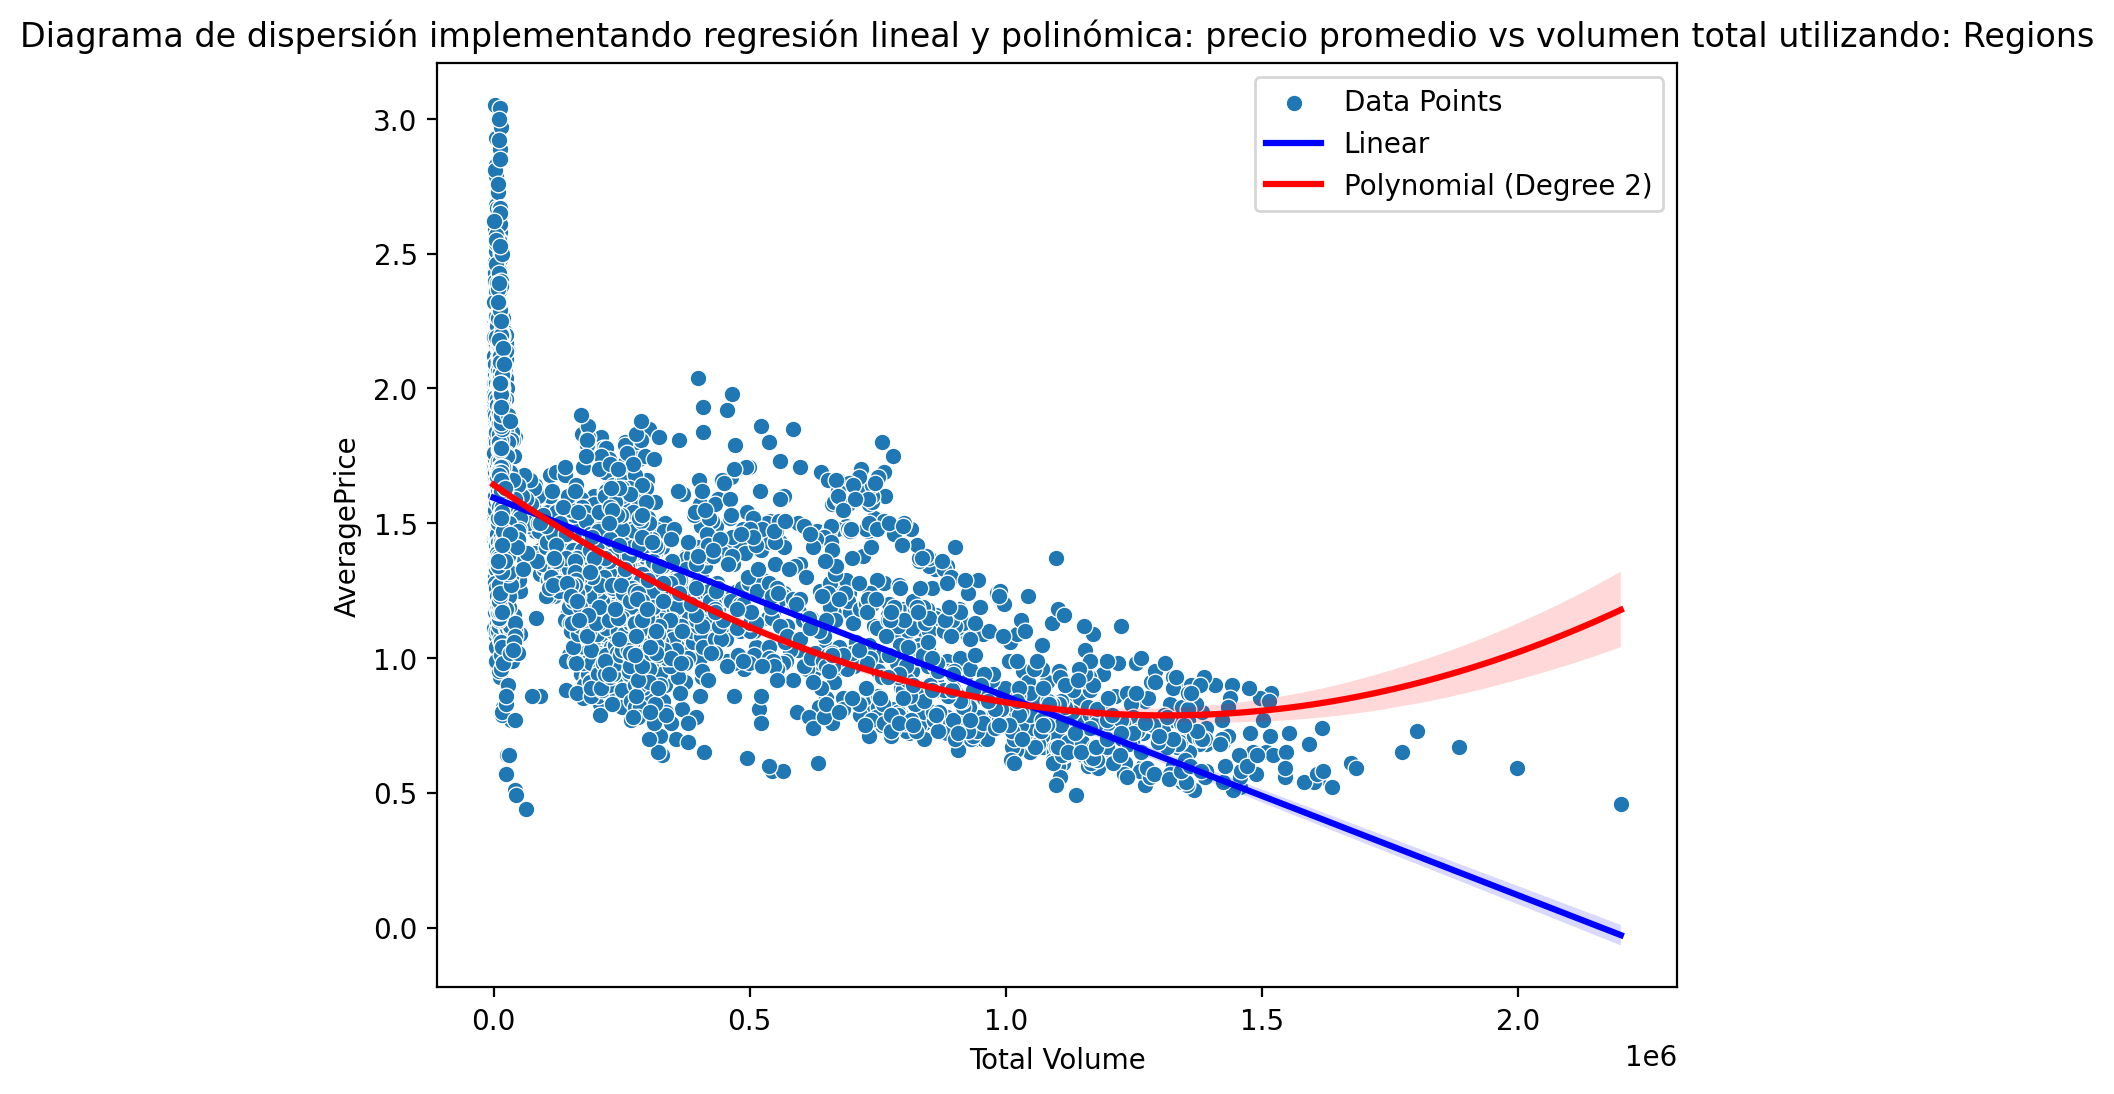

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np

df_filtered = pd.read_csv('/content/CSV/avocado.csv')

df = df_filtered.copy()
# Añade columna con categorización de City/Region/GreaterRegion/TotalUS
df['region_type'] = df['region'].transform(lambda x: get_regions(x))

# Convert 'Date' to datetime if not already done
df['Date'] = pd.to_datetime(df['Date'])
df=df.sort_values(by='Date')

# Create a scatter plot
i = 0;
title = [ "GreaterRegion", "Cities", "Regions" ]
for df2 in [ df_reduced, df_cities, df_regions ]:

    # Initialize the plot
    plt.figure(figsize=(8, 6))

    # Scatter plot with title
    sns.scatterplot(x='Total Volume', y='AveragePrice', data=df2, label='Data Points')

    # Add a linear regression line
    sns.regplot(x='Total Volume', y='AveragePrice', data=df2, scatter=False, label='Linear', color='blue')

    # Add a polynomial regression line (degree=2)
    sns.regplot(x='Total Volume', y='AveragePrice', data=df2, scatter=False, order=2, label='Polynomial (Degree 2)', color='red')

    # Customize the plot
    plt.title(f'Diagrama de dispersión implementando regresión lineal y polinómica: precio promedio vs volumen total utilizando: {title[i]}')
    plt.xlabel('Total Volume')
    plt.ylabel('AveragePrice')
    plt.legend()
    plt.show()
    i += 1

Podríamos concluir que la regresión polinómica de grado 2 es más ajustada, sobretodo en valores de AveragePrice mayores de 1.75



# 5.3 Predicciones Mensuales Usando Datos Trimestrales

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

df_predic=greater_regions[['Date', 'type', 'Total Volume', 'AveragePrice']]
df_prediccion=df_predic.copy()
# Asegurarse de que 'Date' esté en formato datetime
df_prediccion['Date'] = pd.to_datetime(df_prediccion['Date'])

# Ordenar por 'Date' en orden ascendente
df_ordenado_por_fecha = df_prediccion.sort_values(by='Date', ascending=True)

df_ordenado_por_fecha.head(20)

Date          type  Total Volume  AveragePrice
9489  2015-01-04       organic     142349.77          1.24
1559  2015-01-04  conventional    3759282.62          1.09
1871  2015-01-04  conventional    1683795.30          1.01
2391  2015-01-04  conventional    5144267.01          0.77
2443  2015-01-04  conventional    3204112.16          0.98
2755  2015-01-04  conventional    5794410.58          0.89
11881 2015-01-04       organic     187548.30          1.40
363   2015-01-04  conventional    5777334.90          0.93
11569 2015-01-04       organic      27365.89          1.75
831   2015-01-04  conventional    3382800.12          1.02
9957  2015-01-04       organic      61615.10          1.54
11517 2015-01-04       organic      53494.91          1.35
10997 2015-01-04       organic      34190.37          1.69
1351  2015-01-04  conventional    2578275.12          1.10
10477 2015-01-04       organic      58065.35          1.56
10685 2015-01-04       organic      48280.46          1.88
1350  2015-01-11  conventional    2335986.11          1.17
362   2015-01-11  conventional    6024932.34          0.92
2754  2015-01-11  conventional    5333097.71          0.95
1558  2015-01-11  conventional    3056024.77          1.28

FILTRAJE de los dos primeros meses del PRIMER AÑO DEL DATAFRAME SELECCIONADO

In [ ]:
# Obtener el primer año del DataFrame
primer_año = df_ordenado_por_fecha['Date'].dt.year.min()

# Filtrar por los dos primeros meses del primer año
df_filtrado = df_ordenado_por_fecha[
    (df_ordenado_por_fecha['Date'].dt.year == primer_año) &
    (df_ordenado_por_fecha['Date'].dt.month <= 2)
]

df_filtrado

Date          type  Total Volume  AveragePrice
9489  2015-01-04       organic     142349.77          1.24
1559  2015-01-04  conventional    3759282.62          1.09
1871  2015-01-04  conventional    1683795.30          1.01
2391  2015-01-04  conventional    5144267.01          0.77
2443  2015-01-04  conventional    3204112.16          0.98
...          ...           ...           ...           ...
11562 2015-02-22       organic      37584.04          1.59
11510 2015-02-22       organic      81291.05          1.37
9950  2015-02-22       organic      56569.37          1.68
2436  2015-02-22  conventional    2796195.76          1.11
2748  2015-02-22  conventional    5939402.98          0.95

[128 rows x 4 columns]

3r Mes del PRIMER AÑO

In [ ]:
df_filtrado_3r = df_ordenado_por_fecha[
    (df_ordenado_por_fecha['Date'].dt.year == primer_año) &
    (df_ordenado_por_fecha['Date'].dt.month == 3)
]
df_filtrado_3r.head()

Date          type  Total Volume  AveragePrice
9949  2015-03-01       organic      61260.09          1.69
11873 2015-03-01       organic     218957.86          1.40
11561 2015-03-01       organic      47299.44          1.46
1343  2015-03-01  conventional    2538981.60          1.14
1863  2015-03-01  conventional    1619341.49          1.09

# **EVALUACION DEL MODELO**

In [ ]:
#Definimos X e y para el modelo
X=df_filtrado[['Total Volume','AveragePrice']].drop(columns='AveragePrice')
y=df_filtrado['AveragePrice']

# Dividir los datos en conjuntos de entrenamiento y prueba:
#   Tomaremos los 2 primeros meses completos como _train (de ahí, test_size=None);
#   Nuestro _test será el 3r mes
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=None, random_state=None)

# Aplicar un Modelo de Regresión Lineal

# Entrenamos un **modelo de regresión lineal** usando los datos de entrenamiento.
model = LinearRegression()
model.fit(X_train, y_train)

# Ya tenemos los coeficientes y el término independiente!!!
print('Coeficientes: ', model.coef_)
print('Intercepto: ', model.intercept_)

# Sobrescribir conjuntos de prueba X_test y y_test con los valores de nuestro 3r mes
X_test = df_filtrado_3r[['Total Volume','AveragePrice']].drop(columns='AveragePrice')
y_test = df_filtrado_3r['AveragePrice']

# Predecir los valores en el conjunto de prueba
y_pred = model.predict(X_test)

# Comparar Valores Predichos vs Reales

# Comparamos los primeros 10 valores predichos con los valores reales y calculamos
# el **error porcentual**.

comparison_df = pd.DataFrame({
    'Valor Real': y_test.head(10).values,
    'Valor Predicho': y_pred[:10]
})

comparison_df['Error Porcentual'] = ((comparison_df['Valor Real'] - comparison_df['Valor Predicho']) / comparison_df['Valor Real']) * 100

print("\nComparación de los primeros 10 valores entre el valor predicho y el valor real:\n", comparison_df)

# Evaluar el Modelo

# Calculamos el **error cuadrático medio (MSE)** y el valor **R²** para evaluar
# el rendimiento del modelo.

mse = mean_squared_error(y_test, y_pred)
print(f"\nError cuadrático medio (MSE) del modelo: {mse:.4f}")

r2 = r2_score(y_test, y_pred)
print(f"\nValor R² del modelo: {r2:.4f}")

Coeficientes:  [-1.22507271e-07]
Intercepto:  1.5256781845757195

Comparación de los primeros 10 valores entre el valor predicho y el valor real:
    Valor Real  Valor Predicho  Error Porcentual
0        1.69        1.518173         10.167256
1        1.40        1.498854         -7.061018
2        1.46        1.519884         -4.101620
3        1.14        1.214634         -6.546884
4        1.09        1.327297        -21.770374
5        1.70        1.521146         10.520811
6        0.84        0.704863         16.087735
7        1.61        1.518041          5.711730
8        1.15        1.062545          7.604791
9        1.85        1.518720         17.907038

Error cuadrático medio (MSE) del modelo: 0.0268

Valor R² del modelo: 0.7184


## **Una vez evaluado**, graficamos el modelo para una mejor interpretación.

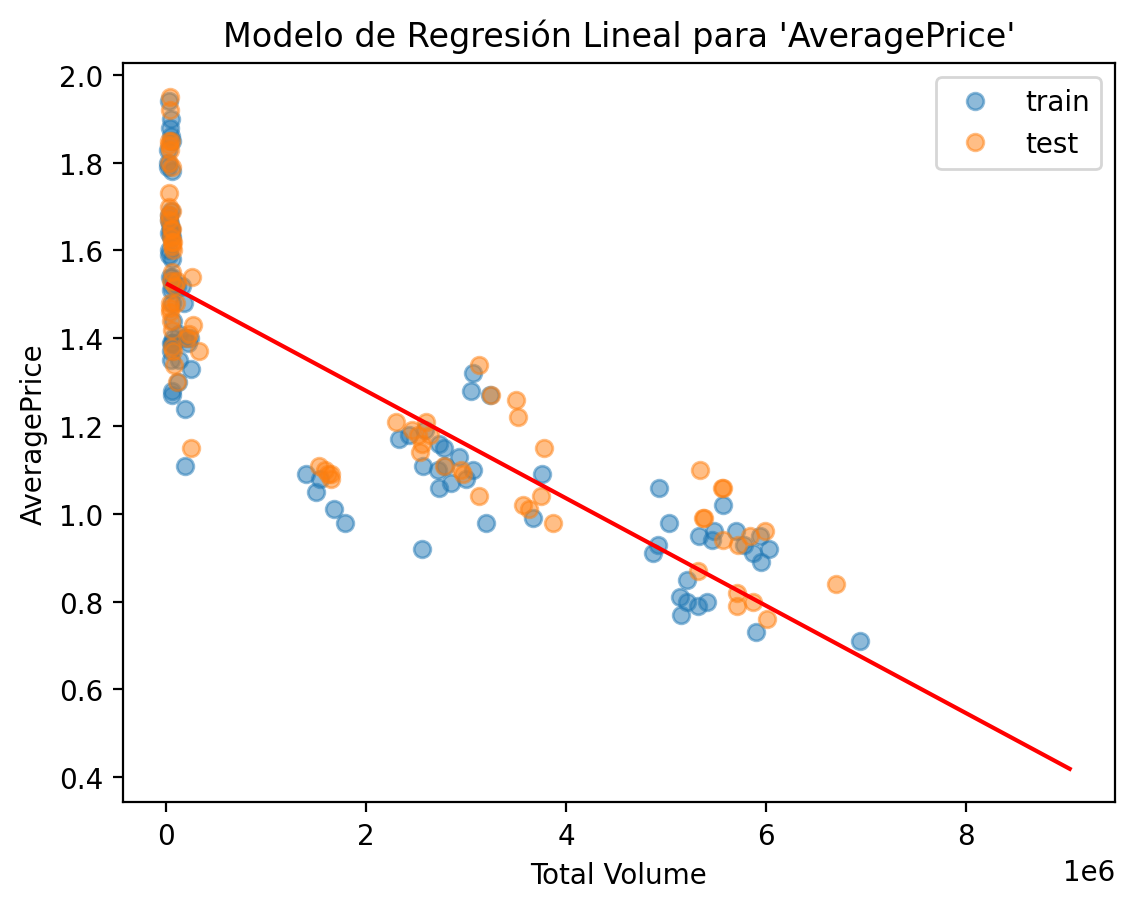

In [ ]:
# Graficar
# Define xmin xmax for the model:
all_three_months = pd.concat([X, X_test], axis=0)
xmin, xmax = round(all_three_months['Total Volume'].min()), round(all_three_months['Total Volume'].max())

x_model = np.arange(xmin, xmax+1) # np.arange returns evenly spaced values within a given interval.
y_model=[model.intercept_+model.coef_*x for x in x_model]

plt.plot(X_train, y_train, "o", alpha=0.5, label="train") # alpha, transparency value, between 0 (transparent) and 1 (opaque).
plt.plot(X_test, y_test, "o", alpha=0.5, label="test") # alpha, transparency value, between 0 (transparent) and 1 (opaque).
plt.plot(x_model, y_model,'r');

plt.title('Modelo de Regresión Lineal para \'AveragePrice\'')
plt.xlabel('Total Volume')
plt.ylabel('AveragePrice')
plt.legend()
plt.show()

El atochamiento inicial probablemente es debido a que el volumen de aguacates orgánicos es mucho menor.

Esto nos sugiere efectuar predicciones separadas para orgánico y convencional.

MODELO para aguacates de tipo "ORGANIC":
Error cuadrático medio (MSE) del modelo: 0.0292
Valor R² del modelo: 0.1300

MODELO para aguacates de tipo "CONVENTIONAL":
Error cuadrático medio (MSE) del modelo: 0.0099
Valor R² del modelo: 0.4804



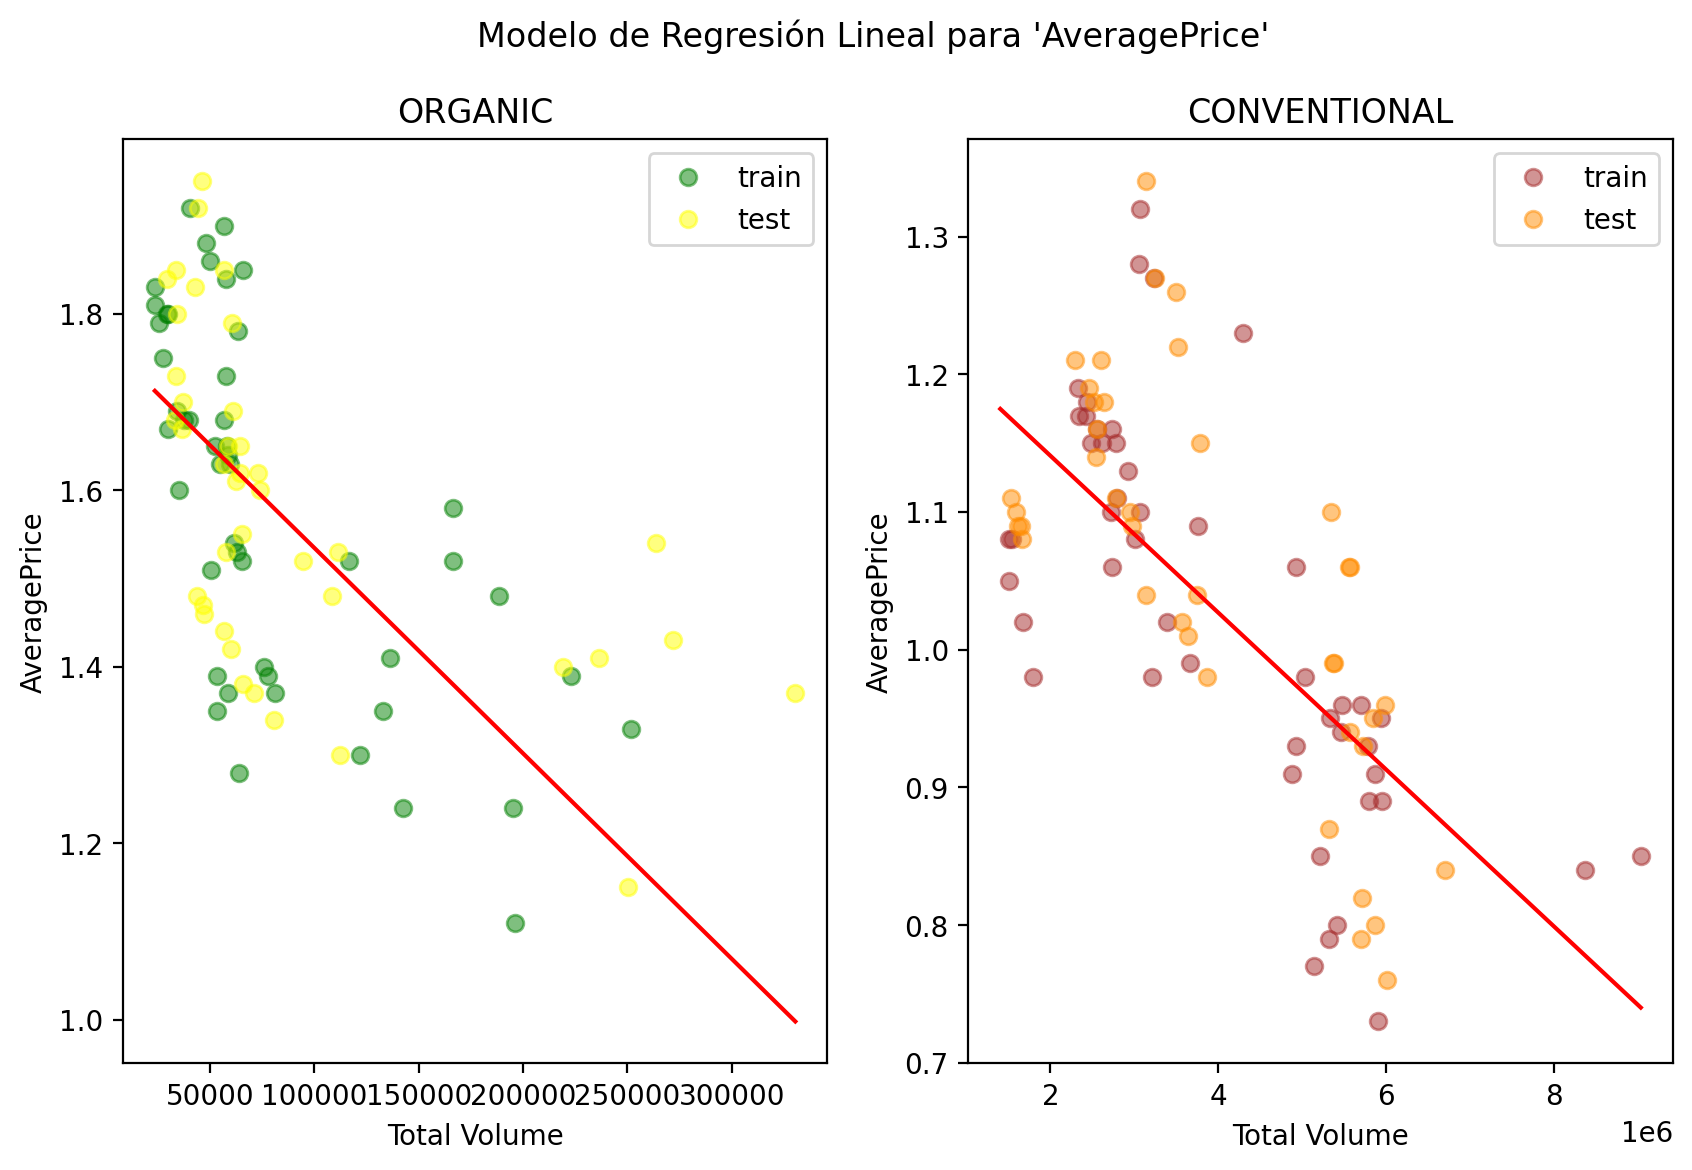

In [ ]:
# ORGANICO
fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharex=False)
fig.suptitle('Modelo de Regresión Lineal para \'AveragePrice\'')
for tipo in df_filtrado.type.unique():
    df_tipo = df_filtrado[df_filtrado['type']==tipo].copy()
    df_tipo_3r = df_filtrado_3r[df_filtrado_3r['type']==tipo].copy()

    X=df_tipo[['Total Volume','AveragePrice']].drop(columns='AveragePrice')
    y=df_tipo['AveragePrice']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=None, random_state=None)

    print(f'MODELO para aguacates de tipo "{tipo.upper()}":')

    # Entrenar modelo
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Sobrescribir conjuntos de prueba X_test y y_test con los valores de nuestro 3r mes
    X_test = df_tipo_3r[['Total Volume','AveragePrice']].drop(columns='AveragePrice')
    y_test = df_tipo_3r['AveragePrice']

    y_pred = model.predict(X_test)

    # Evaluar el Modelo
    mse = mean_squared_error(y_test, y_pred)
    print(f"Error cuadrático medio (MSE) del modelo: {mse:.4f}")
    r2 = r2_score(y_test, y_pred)
    print(f"Valor R² del modelo: {r2:.4f}")
    print()

    # Preparar gráficas
    all_three_months = pd.concat([X, X_test], axis=0)
    xmin, xmax = round(all_three_months['Total Volume'].min()), round(all_three_months['Total Volume'].max())

    x_model = np.arange(xmin, xmax+1) # np.arange returns evenly spaced values within a given interval.
    y_model=[model.intercept_+model.coef_*x for x in x_model]

    index_graf = 0 if tipo=='organic' else 1
    color_graf_strong = 'green' if tipo=='organic' else 'brown'
    color_graf_light = 'yellow' if tipo=='organic' else 'red'
    axs[index_graf].plot(X_train, y_train, "o", color=color_graf_strong, alpha=0.5, label="train") # alpha, transparency value, between 0 (transparent) and 1 (opaque).
    axs[index_graf].plot(X_test, y_test, "o", color=color_graf_light, alpha=0.5, label="test") # alpha, transparency value, between 0 (transparent) and 1 (opaque).
    axs[index_graf].plot(x_model, y_model,'r');
    axs[index_graf].set_title(tipo.upper())
    axs[index_graf].set_xlabel('Total Volume')
    axs[index_graf].set_ylabel('AveragePrice')
    if tipo=='organic': axs[index_graf].legend()
    axs[index_graf].legend()

# 5.3 VERSION 2

Dataset: Filtered Data
R²: -0.16299906632648753
RMSE: 0.24508957908438928



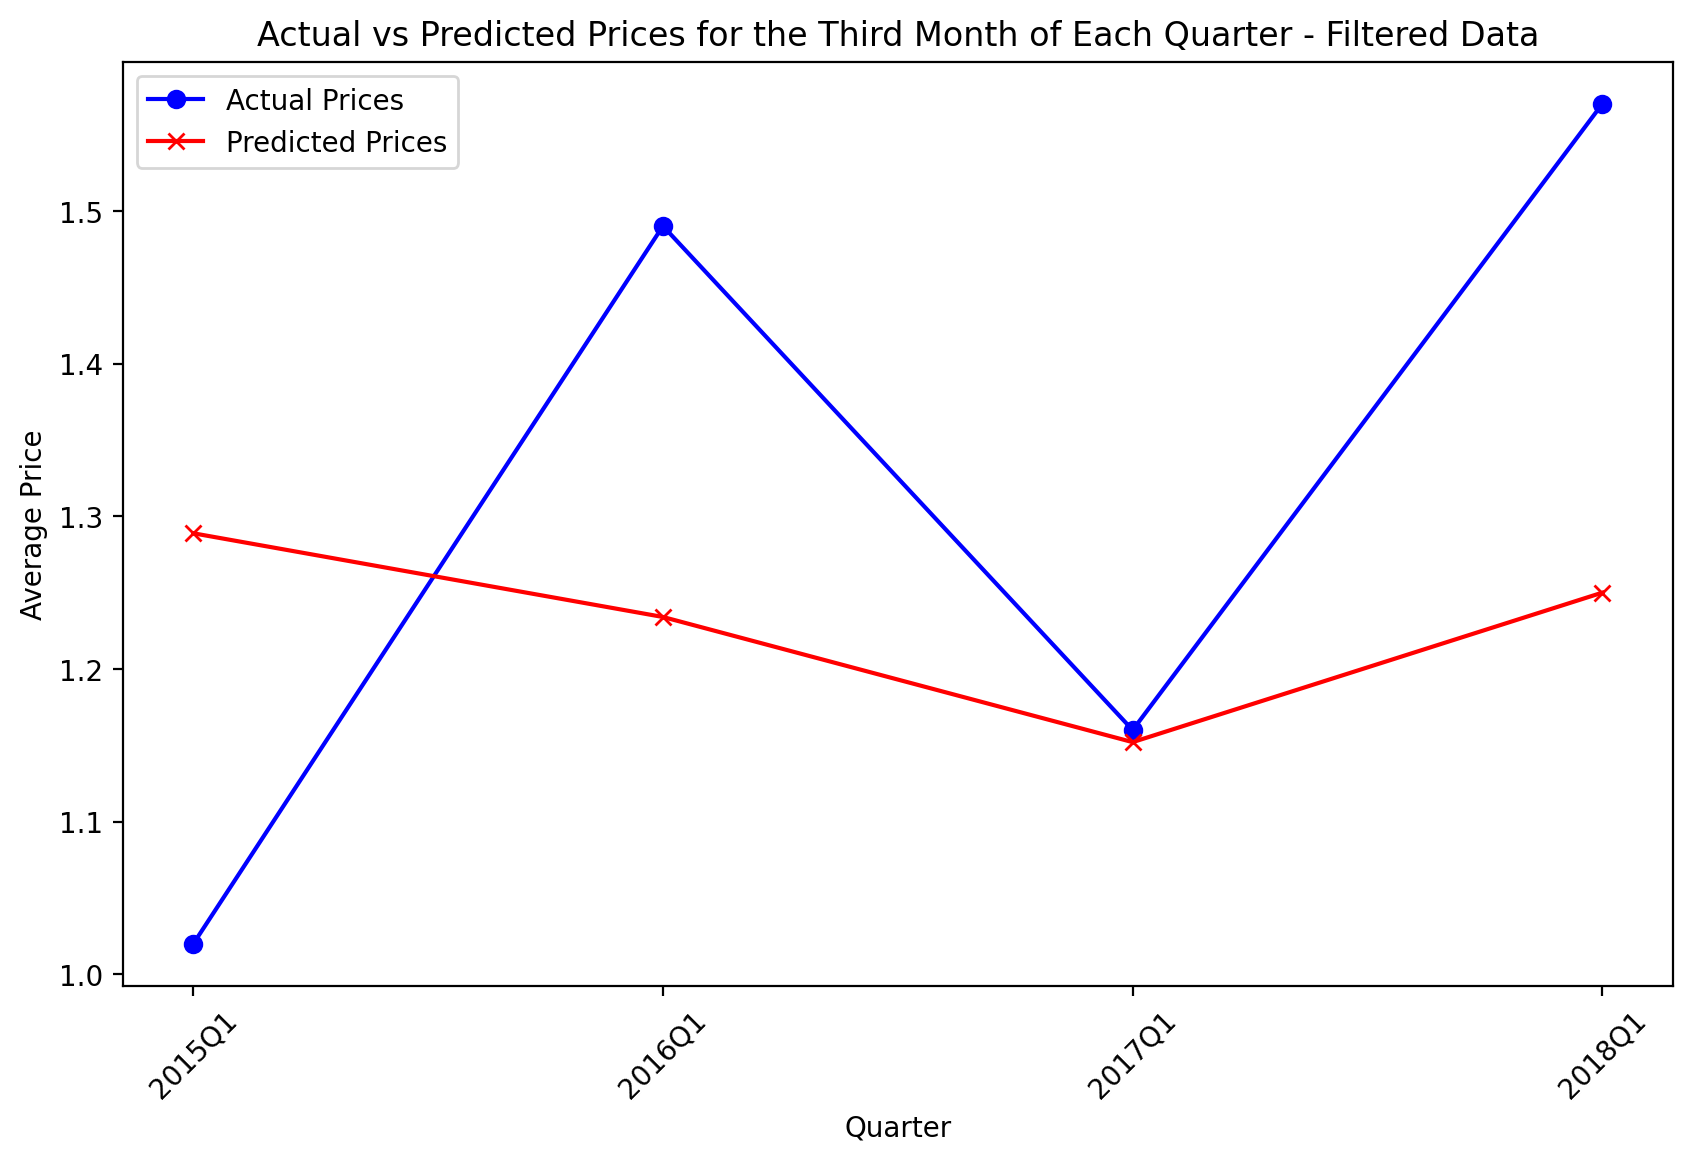

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

df_filtered = pd.read_csv('/content/CSV/avocado.csv')

df = df_filtered.copy()
# Añade columna con categorización de City/Region/GreaterRegion/TotalUS
df['region_type'] = df['region'].transform(lambda x: get_regions(x))

# Convert 'Date' to datetime if not already done
df['Date'] = pd.to_datetime(df['Date'])

# List of dataframes to loop through
dataframes = [df]
titles = ["Filtered Data"]
# Loop over each dataset
for idx, data in enumerate(dataframes):
    data['Quarter'] = data['Date'].dt.to_period('Q')
    data['Month'] = data['Date'].dt.month

    # Initialize lists for storing predictions and actual values
    predicted_prices = []
    actual_prices = []
    quarters = []

    for quarter in data['Quarter'].unique():
        # Filter data for the current quarter
        quarter_data = data[data['Quarter'] == quarter]

        # Separate the first two months and third month of the quarter
        first_two_months = quarter_data[quarter_data['Month'] <= 2]
        third_month = quarter_data[quarter_data['Month'] == 3]

        # Ensure we have enough data
        if len(first_two_months) >= 2 and not third_month.empty:
            # Prepare training data (first two months)
            X_train = np.array(first_two_months['Month']).reshape(-1, 1)
            y_train = first_two_months['AveragePrice'].values

            # Train a linear regression model
            model = LinearRegression()
            model.fit(X_train, y_train)

            # Predict the third month using the trained model
            predicted_price = model.predict([[3]])[0]
            predicted_prices.append(predicted_price)

            # Store the actual price for the third month
            actual_price = third_month['AveragePrice'].values[0]
            actual_prices.append(actual_price)
            quarters.append(str(quarter))

    # Convert to numpy arrays for evaluation
    predicted_prices = np.array(predicted_prices)
    actual_prices = np.array(actual_prices)

    # Calculate evaluation metrics
    r2 = r2_score(actual_prices, predicted_prices)
    rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))

    print(f"Dataset: {titles[idx]}")
    print(f"R²: {r2}")
    print(f"RMSE: {rmse}\n")

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(quarters, actual_prices, label='Actual Prices', marker='o', color='b')
    plt.plot(quarters, predicted_prices, label='Predicted Prices', marker='x', color='r')
    plt.title(f"Actual vs Predicted Prices for the Third Month of Each Quarter - {titles[idx]}")
    plt.xlabel('Quarter')
    plt.ylabel('Average Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

# 5.4 Predicciones  Trimestrales

Dataset: Reduced Data
R²: -0.2642162841820004
RMSE: 0.14863278067088018



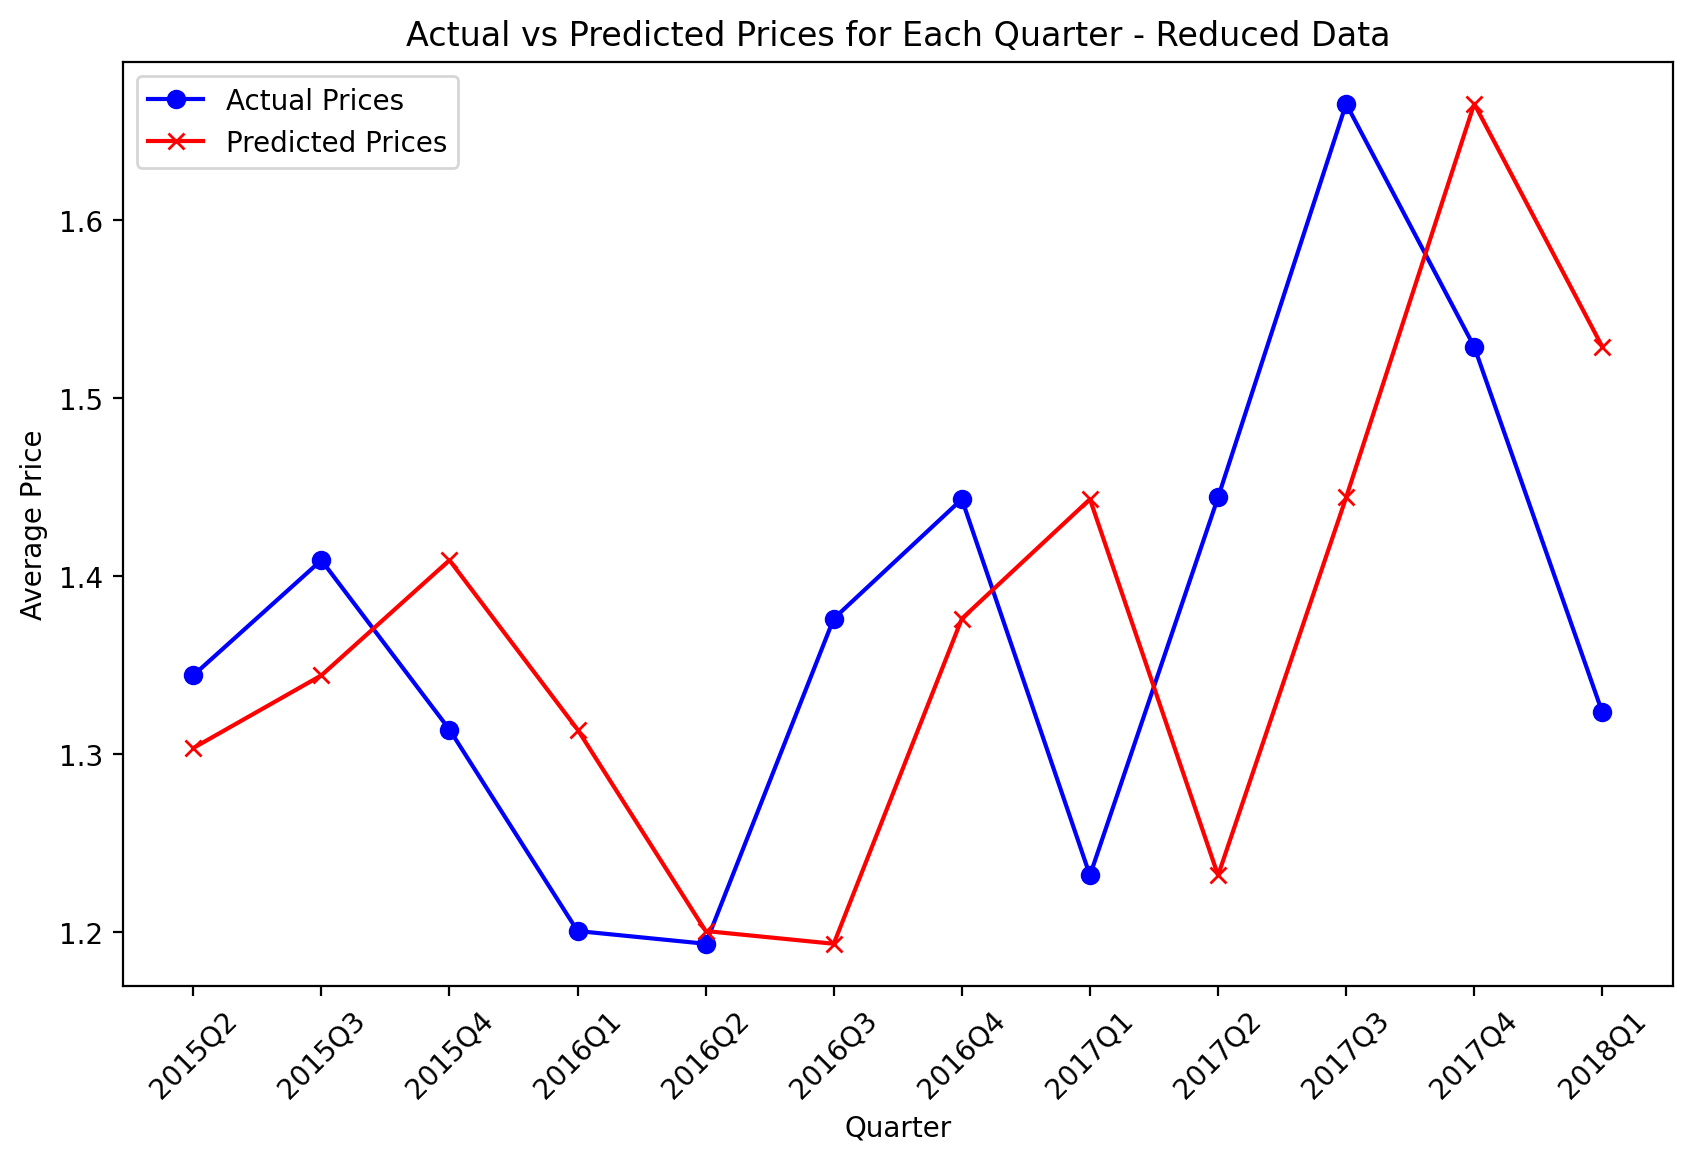

Dataset: Cities Data
R²: -0.17252598461364577
RMSE: 0.1523441903889465



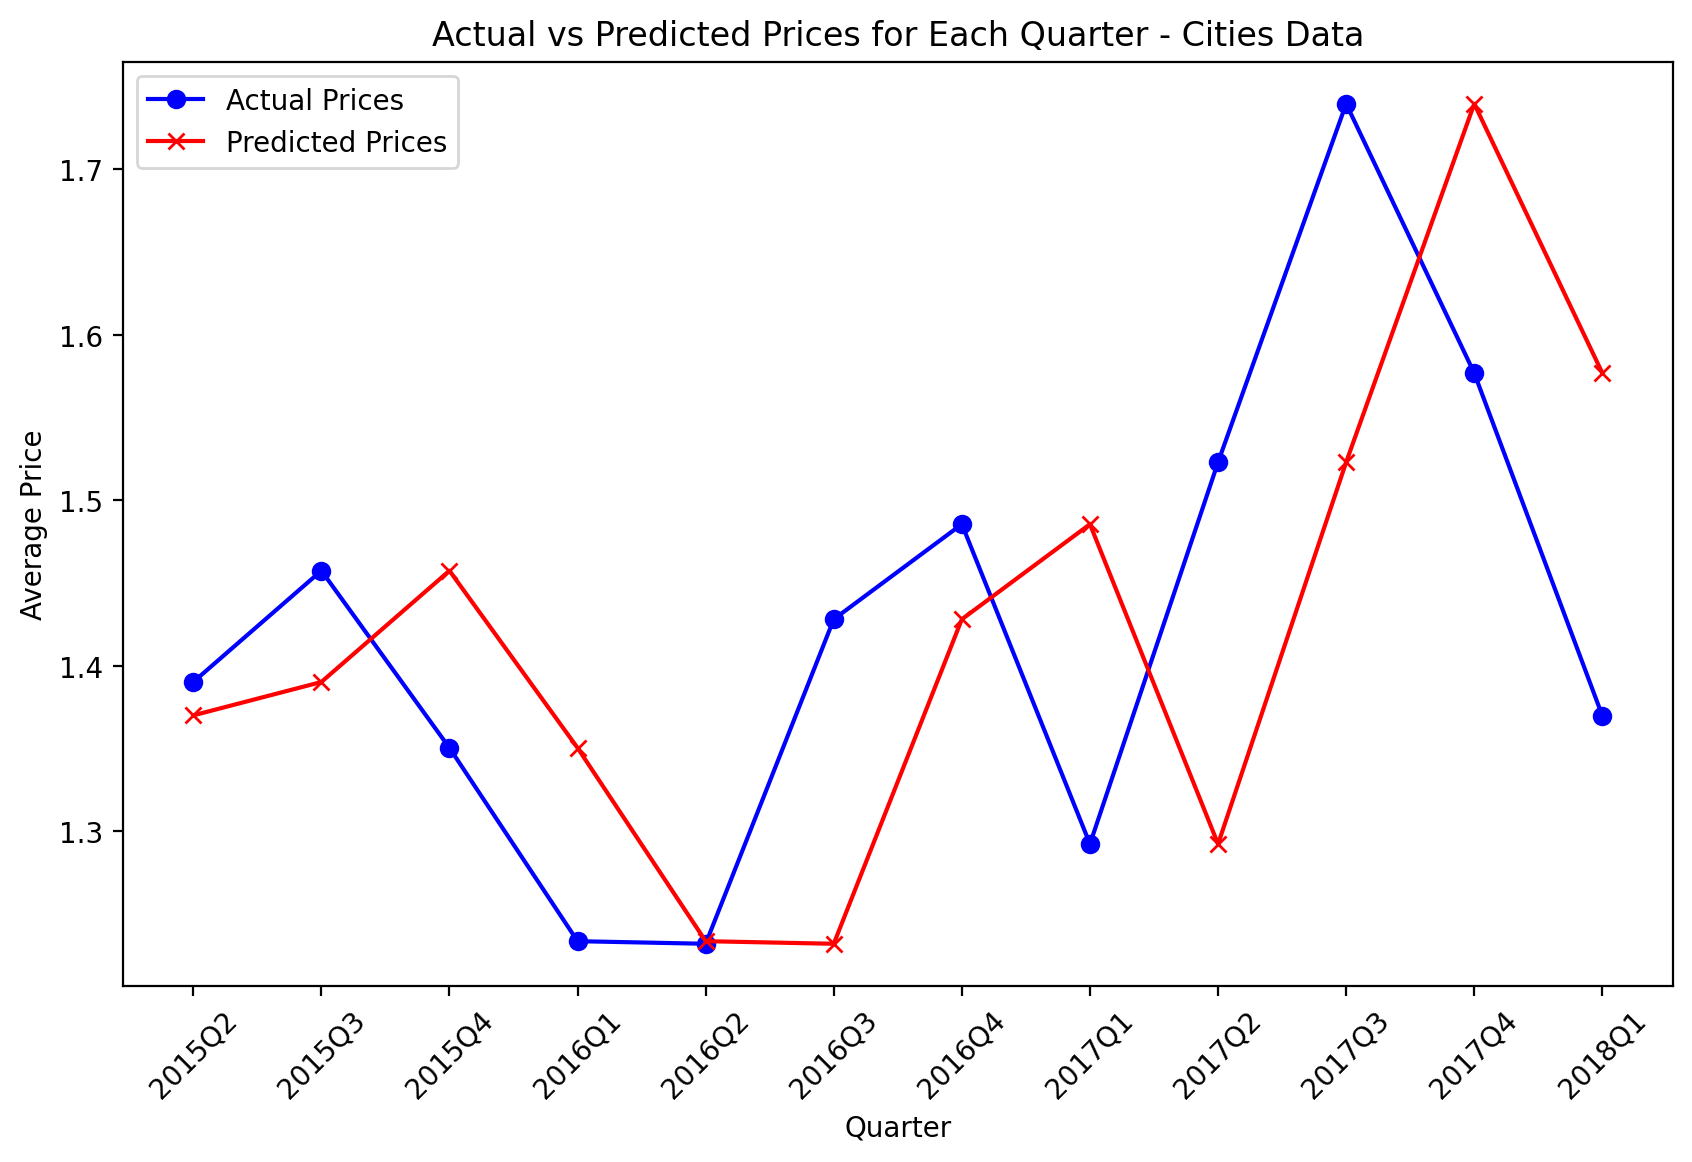

Dataset: Regions Data
R²: -0.11233983155187843
RMSE: 0.11890177011939505



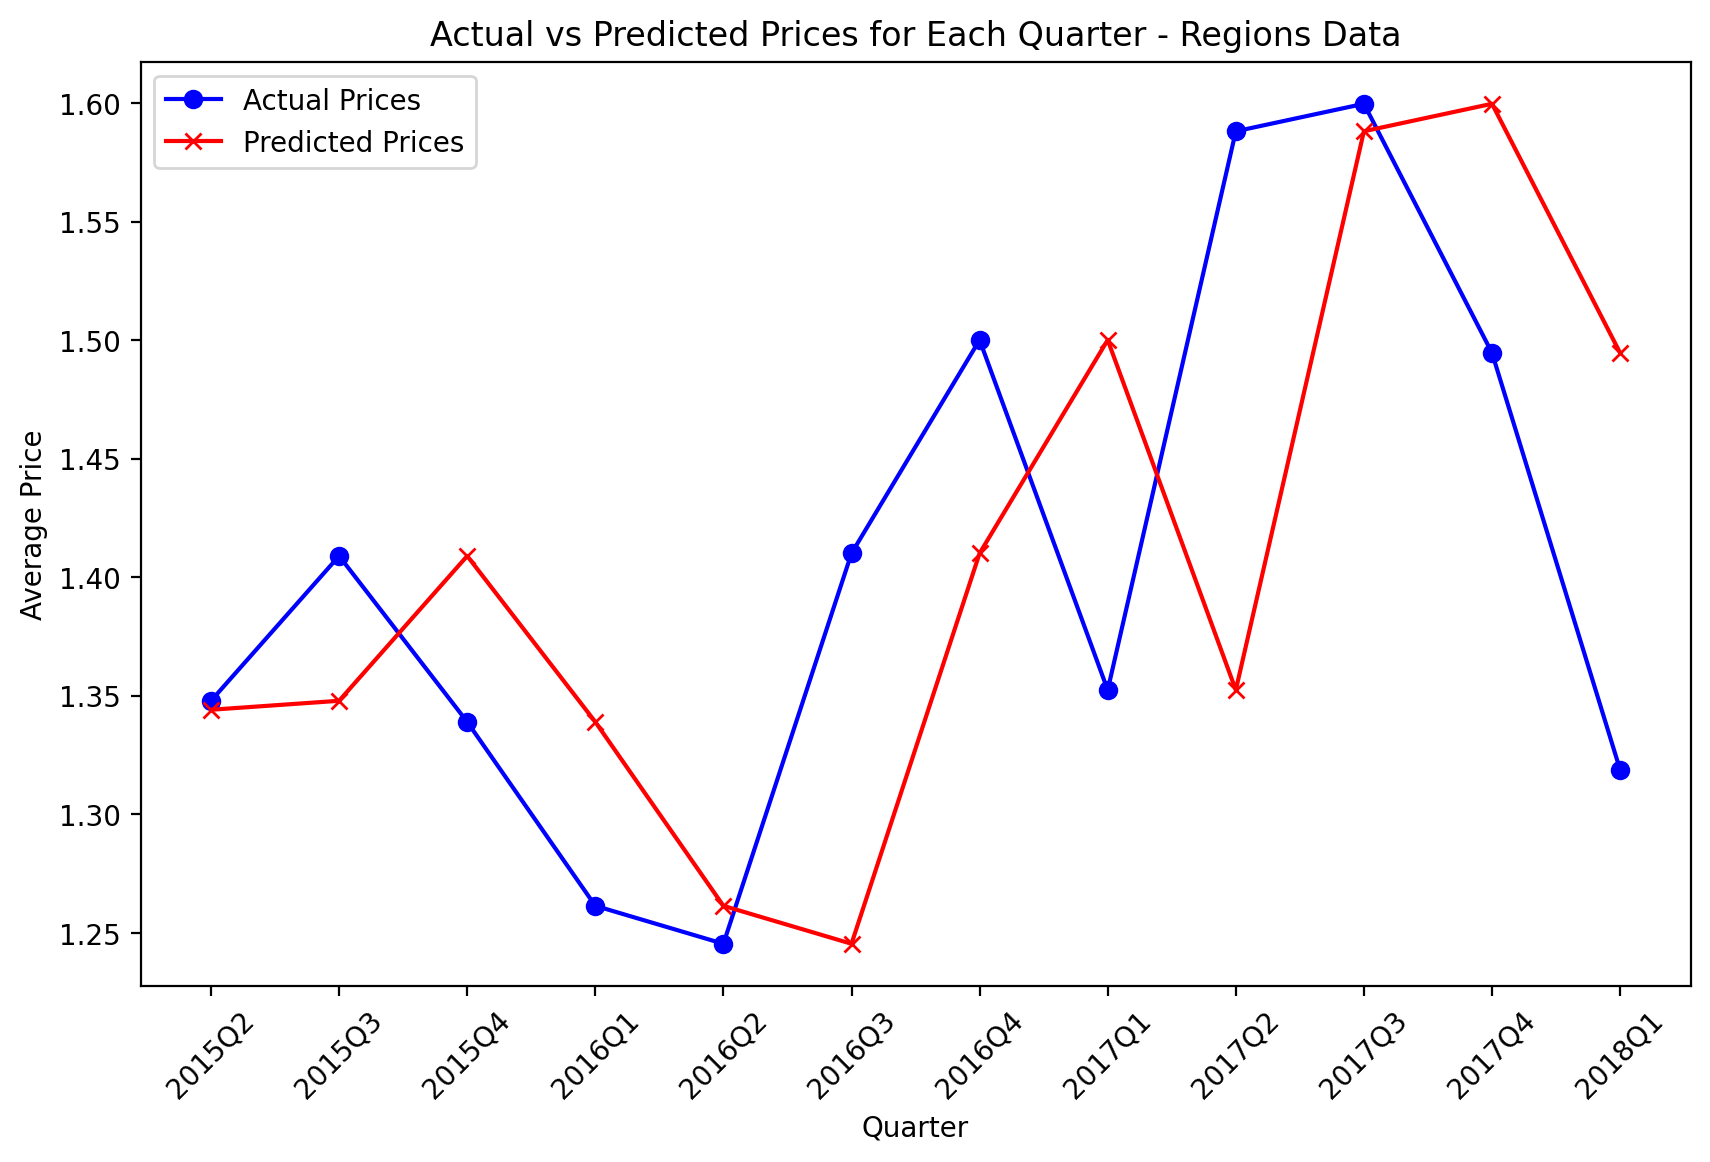

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

df_filtered = pd.read_csv('/content/CSV/avocado.csv')

df = df_filtered.copy()
# Añade columna con categorización de City/Region/GreaterRegion/TotalUS
df['region_type'] = df['region'].transform(lambda x: get_regions(x))

# Convert 'Date' to datetime if not already done
df['Date'] = pd.to_datetime(df['Date'])

# List of dataframes to loop through
dataframes = [df]
titles = ["Filtered Data"]

# Loop over each dataset
for idx, data in enumerate(dataframes):
    # Convert Date to datetime and create a column for Quarter
    data['Quarter'] = data['Date'].dt.to_period('Q')

    # Group data by quarter and calculate the average for 'AveragePrice' and 'Total Volume'
    quarterly_data = data.groupby('Quarter').agg({
        'AveragePrice': 'mean',
        'Total Volume': 'mean'
    }).reset_index()

    # Initialize lists for storing predictions and actual values
    predicted_prices = []
    actual_prices = []
    quarters = []

    # Loop through each quarter, using previous quarters to predict the next quarter
    for i in range(len(quarterly_data) - 1):
        # Define the current quarter as the target to predict
        current_quarter = quarterly_data.iloc[i]
        next_quarter = quarterly_data.iloc[i + 1]

        # Prepare training data (average price of current quarter to predict next)
        X_train = np.array([[i]])
        y_train = current_quarter['AveragePrice']

        # Predict the next quarter's price
        model = LinearRegression()
        model.fit(X_train, [y_train])
        predicted_price = model.predict([[i + 1]])[0]
        predicted_prices.append(predicted_price)

        # Store the actual price for the next quarter
        actual_price = next_quarter['AveragePrice']
        actual_prices.append(actual_price)

        # Save the quarter label for plotting
        quarters.append(str(next_quarter['Quarter']))

    # Convert to numpy arrays for evaluation
    predicted_prices = np.array(predicted_prices)
    actual_prices = np.array(actual_prices)

    # Calculate evaluation metrics
    r2 = r2_score(actual_prices, predicted_prices)
    rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))

    print(f"Dataset: {titles[idx]}")
    print(f"R²: {r2}")
    print(f"RMSE: {rmse}\n")

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(quarters, actual_prices, label='Actual Prices', marker='o', color='b')
    plt.plot(quarters, predicted_prices, label='Predicted Prices', marker='x', color='r')
    plt.title(f"Actual vs Predicted Prices for Each Quarter - {titles[idx]}")
    plt.xlabel('Quarter')
    plt.ylabel('Average Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

# **5.5 Uso de Datos:** Agrupa los datos en años, utilizando únicamente columnas numéricas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np

df_filtered = pd.read_csv('/content/CSV/avocado.csv')

df = df_filtered.copy()
# Añade columna con categorización de City/Region/GreaterRegion/TotalUS
df['region_type'] = df['region'].transform(lambda x: get_regions(x))

# Convert 'Date' to datetime if not already done
df['Date'] = pd.to_datetime(df['Date'])
df=df.sort_values(by='Date')
df_prediccion = df.copy()

df_anual=df_prediccion.groupby(pd.Grouper(key='Date', freq='YE')).agg({'AveragePrice': 'mean', 'Total Volume': 'mean'})
#Preparamos los datos
X = []
y_avg_price = []
y_total_volume = []
df_anual

AveragePrice  Total Volume
Date                                  
2015-12-31      1.375590  7.810274e+05
2016-12-31      1.338640  8.584206e+05
2017-12-31      1.515128  8.623393e+05
2018-12-31      1.347531  1.066928e+06

In [ ]:
for i in range(2, len(df_anual)):
    # Dos trimestres anteriores
    X.append([df_anual['AveragePrice'].iloc[i-1], df_anual['AveragePrice'].iloc[i-2],
            df_anual['Total Volume'].iloc[i-1], df_anual['Total Volume'].iloc[i-2]])
    # Valor del trimestre a predecir
    y_avg_price.append(df_anual['AveragePrice'].iloc[i])
    y_total_volume.append(df_anual['Total Volume'].iloc[i])

X = pd.DataFrame(X, columns=['AvgPrice_Y1', 'AvgPrice_Y2', 'TotalVolume_Y1', 'TotalVolume_Y2'])
y_avg_price = pd.Series(y_avg_price)
y_total_volume = pd.Series(y_total_volume)

In [ ]:
# Función para entrenar y evaluar modelos
def train_and_evaluate_models(X, y):
    # Modelo Lineal
    linear_model = LinearRegression()
    linear_model.fit(X, y)
    y_pred_linear = linear_model.predict(X)

    # Modelo Polinómico (grados 2)
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y)
    y_pred_poly = poly_model.predict(X_poly)

    return y_pred_linear, y_pred_poly

y_pred_linear_avg_price, y_pred_poly_avg_price = train_and_evaluate_models(X, y_avg_price)

In [ ]:
# Evaluar AveragePrice
print("\nEvaluación para AveragePrice con modelo de regresión Lineal:")
rmse_linear_avg_price = root_mean_squared_error(y_avg_price, y_pred_linear_avg_price)
r2_linear_avg_price = r2_score(y_avg_price, y_pred_linear_avg_price)
print("RMSE:", rmse_linear_avg_price)
print("R^2:", r2_linear_avg_price)

print("\nEvaluación para AveragePrice con modelo de regresión Polinómica:")
y_pred_poly_avg_price = train_and_evaluate_models(X, y_avg_price)[1]
rmse_poly_avg_price = root_mean_squared_error(y_avg_price, y_pred_poly_avg_price)
r2_poly_avg_price = r2_score(y_avg_price, y_pred_poly_avg_price)

print("RMSE:", rmse_poly_avg_price)
print("R^2:", r2_poly_avg_price)


Evaluación para AveragePrice con modelo de regresión Lineal:
RMSE: 2.220446049250313e-16
R^2: 1.0

Evaluación para AveragePrice con modelo de regresión Polinómica:
RMSE: 2.220446049250313e-16
R^2: 1.0


In [ ]:
# Ajustar y evaluar para Total Volume
y_pred_linear_total_volume, y_pred_poly_total_volume = train_and_evaluate_models(X, y_total_volume)

# Evaluar Total Volume
print("\nEvaluación para Total Volume con modelo de regresión Lineal:")
rmse_linear_total_volume = root_mean_squared_error(y_total_volume, y_pred_linear_total_volume)
r2_linear_total_volume = r2_score(y_total_volume, y_pred_linear_total_volume)

print("RMSE:", rmse_linear_total_volume)
print("R^2:", r2_linear_total_volume)

print("\nEvaluación para Total Volume con modelo de regresión Polinómica:")
rmse_poly_total_volume = root_mean_squared_error(y_total_volume, y_pred_poly_total_volume)
r2_poly_total_volume = r2_score(y_total_volume, y_pred_poly_total_volume)

print("RMSE:", rmse_poly_total_volume)
print("R^2:", r2_poly_total_volume)


Evaluación para Total Volume con modelo de regresión Lineal:
RMSE: 8.231806349783991e-11
R^2: 1.0

Evaluación para Total Volume con modelo de regresión Polinómica:
RMSE: 1.8406878575731415e-10
R^2: 1.0


# 5.5 VERSION 2

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# List of dataframes to loop through
dataframes = [df_reduced, df_cities, df_regions]
titles = ["Reduced Data", "Cities Data", "Regions Data"]

# Loop over each dataset
for idx, data in enumerate(dataframes):
    # Convert Date to datetime and create a column for Quarter
    data['Annual'] = data['Date'].dt.to_period('Y')

    # Group data by quarter and calculate the average for 'AveragePrice' and 'Total Volume'
    quarterly_data = data.groupby('Annual').agg({
        'AveragePrice': 'mean',
        'Total Volume': 'mean'
    }).reset_index()

    # Initialize lists for storing predictions and actual values
    predicted_prices = []
    actual_prices = []
    quarters = []

    # Loop through each quarter, using previous quarters to predict the next quarter
    for i in range(len(quarterly_data) - 1):
        # Define the current quarter as the target to predict
        current_quarter = quarterly_data.iloc[i]
        next_quarter = quarterly_data.iloc[i + 1]

        # Prepare training data (average price of current quarter to predict next)
        X_train = np.array([[i]])
        y_train = current_quarter['AveragePrice']

        # Predict the next quarter's price
        model = LinearRegression()
        model.fit(X_train, [y_train])
        predicted_price = model.predict([[i + 1]])[0]
        predicted_prices.append(predicted_price)

        # Store the actual price for the next quarter
        actual_price = next_quarter['AveragePrice']
        actual_prices.append(actual_price)

        # Save the quarter label for plotting
        quarters.append(str(next_quarter['Annual']))

    # Convert to numpy arrays for evaluation
    predicted_prices = np.array(predicted_prices)
    actual_prices = np.array(actual_prices)

    # Calculate evaluation metrics
    r2 = r2_score(actual_prices, predicted_prices)
    rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))

    print(f"Dataset: {titles[idx]}")
    print(f"R²: {r2}")
    print(f"RMSE: {rmse}\n")

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(quarters, actual_prices, label='Actual Prices', marker='o', color='b')
    plt.plot(quarters, predicted_prices, label='Predicted Prices', marker='x', color='r')
    plt.title(f"Actual vs Predicted Prices for Each Year - {titles[idx]}")
    plt.xlabel('Annual')
    plt.ylabel('Average Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

NameError: name 'df_reduced' is not defined

# 5.6 Desarrollo de Modelos de Regresión Múltiple


Dataset: Filtered Data
R²: 0.04598825570847109
RMSE: 0.38775478025938076


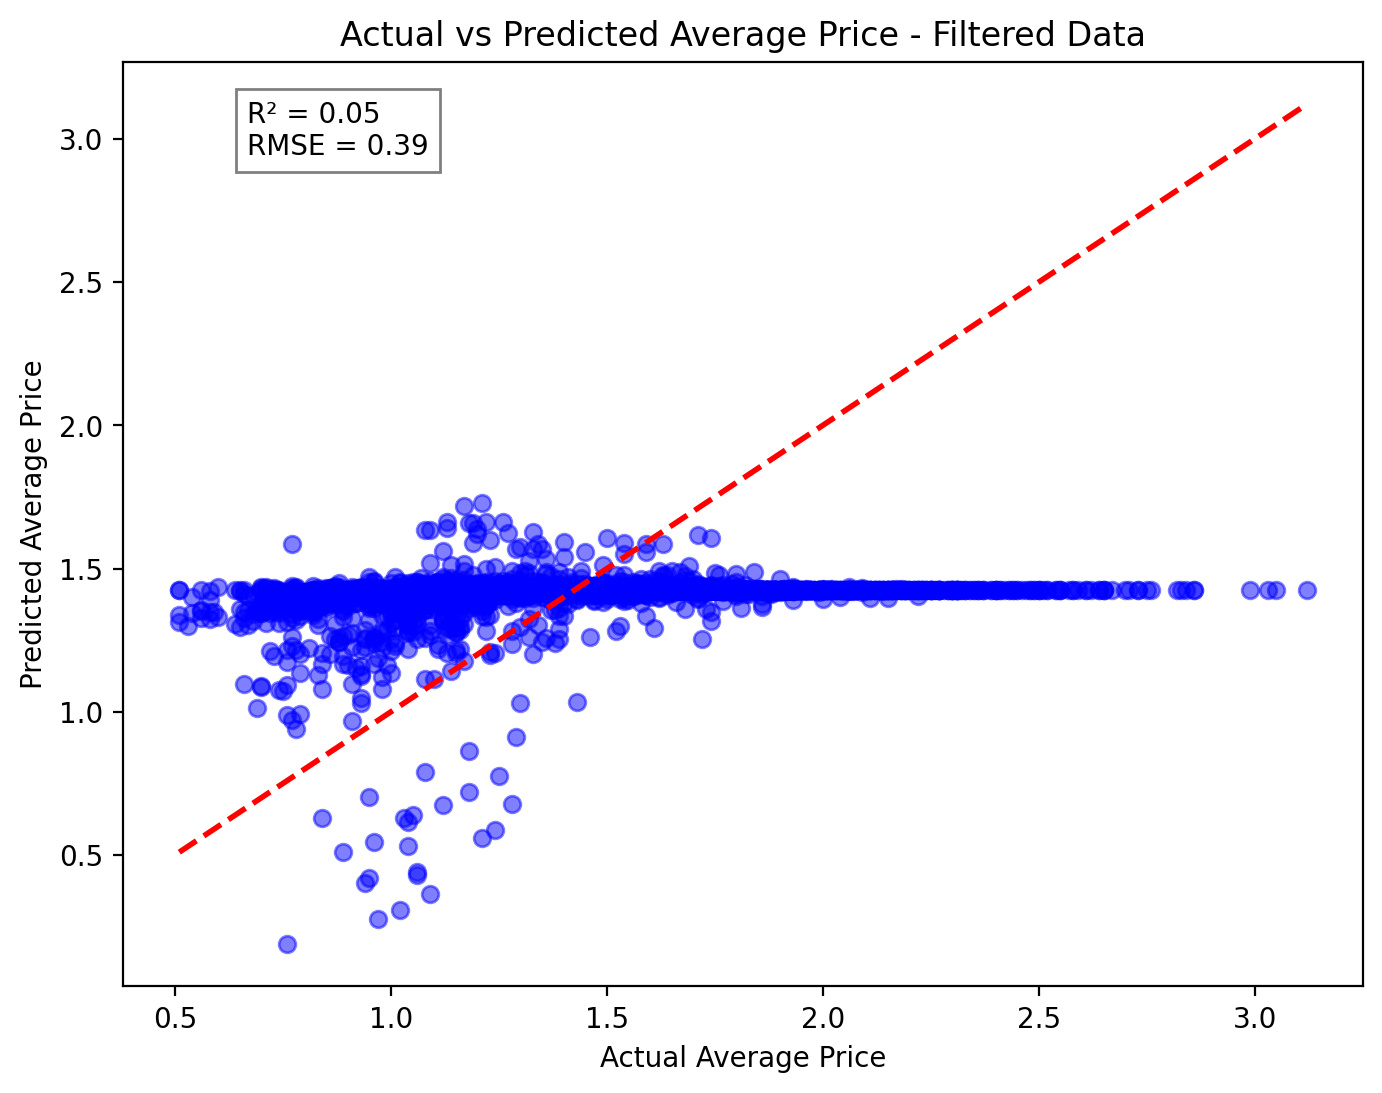

In [ ]:
"""
Desarrollo de Modelos de Regresión Múltiple:

Uso de Datos: Selecciona varias variables numéricas como Total Volume, 4046, 4225, 4770, y Total Bags para predecir AveragePrice.
Esperado:
Define las variables independientes (X) y dependientes (y).
Ajusta modelos de regresión múltiple.
Compara su rendimiento utilizando métricas como R² y RMSE y discute las implicaciones de los resultados.
"""
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

df_filtered = pd.read_csv('/content/CSV/avocado.csv')

df = df_filtered.copy()
# Añade columna con categorización de City/Region/GreaterRegion/TotalUS
df['region_type'] = df['region'].transform(lambda x: get_regions(x))

# Convert 'Date' to datetime if not already done
df['Date'] = pd.to_datetime(df['Date'])
df=df.sort_values(by='Date')

# List of dataframes to loop through
dataframes = [df]
titles = ["Filtered Data"]

# Loop over each dataset
for idx, data in enumerate(dataframes):
    # Definimos las variables
    X = data[['Total Volume', '4046', '4225', '4770', 'Total Bags']]
    y = data['AveragePrice']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and fit the regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Print results
    print(f"\nDataset: {titles[idx]}")
    print(f"R²: {r2}")
    print(f"RMSE: {rmse}")

    # Plot Actual vs. Predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, color='b')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Line y=x
    plt.title(f'Actual vs Predicted Average Price - {titles[idx]}')
    plt.xlabel('Actual Average Price')
    plt.ylabel('Predicted Average Price')
    plt.text(0.1, 0.9, f'R² = {r2:.2f}\nRMSE = {rmse:.2f}', transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

# **2A Version**

In [ ]:
df_ej6=greater_regions[['Total Volume', '4046','4225','4770','Total Bags', 'AveragePrice']]
df_ej6=df_ej6.copy()
df_ej6.head()

Total Volume        4046        4225       4770  Total Bags  AveragePrice
312    5040365.47  1833946.59  1760956.02  232755.85  1212707.01          0.90
313    4695737.21  1676601.43  1543280.76  266689.82  1209165.20          0.94
314    5259354.30  1806690.08  1627240.76  232985.13  1592438.33          0.87
315    5775536.27  1943065.50  2100246.17  221957.26  1510267.34          0.78
316    4575710.62  1461699.38  1810202.70  222311.07  1081497.47          0.91

In [ ]:
#Vamos a definir las variables
X=df_ej6[['Total Volume', '4046','4225','4770','Total Bags']]
y=df_ej6['AveragePrice']

# Función para entrenar modelos y hacer predicciones
def train_and_evaluate_models(X, y):
    # Modelo Lineal
    linear_model = LinearRegression()
    linear_model.fit(X, y)
    y_pred_linear = linear_model.predict(X)

    # Extraer coeficientes e intercepto del modelo lineal
    pesos_lineal = linear_model.coef_
    intercept_lineal = linear_model.intercept_

    # Modelo Polinómico (grados 2)
    from sklearn.preprocessing import PolynomialFeatures # import PolynomialFeatures here
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y)
    y_pred_poly = poly_model.predict(X_poly)

    # Extraer coeficientes e intercepto del modelo polinomial
    pesos_poly = poly_model.coef_
    intercept_poly = poly_model.intercept_

    # Guardamos las características generadas
    feature_names = poly.get_feature_names_out(X.columns)

    return y_pred_linear, y_pred_poly, pesos_lineal, pesos_poly, intercept_lineal, intercept_poly, feature_names

# Ajustar y evaluar para AveragePrice
y_pred_linear, y_pred_poly, pesos_lineal, pesos_poly, intercept_lineal, intercept_poly, feature_names = train_and_evaluate_models(X, y)

In [ ]:
# ipython-input-33-16a84042a42c

# Evaluar AveragePrice
print("Evaluación para AveragePrice con modelo de Regresión Lineal")
# Use y_pred_linear from the current cell's context
print("\nRMSE:", mean_squared_error(y, y_pred_linear))  # Changed from y_pred_linear_avg_price
print("R^2:", r2_score(y, y_pred_linear))  # Changed from y_pred_linear_avg_price

print("\nEvaluación para AveragePrice con modelo de Regresión Polinómica")
# Use y_pred_poly from the current cell's context
print("\nRMSE:", mean_squared_error(y, y_pred_poly))  # Changed from y_pred_poly_avg_price
print("R^2:", r2_score(y, y_pred_poly))  # Changed from y_pred_poly_avg_price

Evaluación para AveragePrice con modelo de Regresión Lineal

RMSE: 0.055323473782638175
R^2: 0.5472726729669551

Evaluación para AveragePrice con modelo de Regresión Polinómica

RMSE: 0.052086027764275546
R^2: 0.5737655914714156


In [ ]:
# Evaluar AveragePrice
print("Evaluación para AveragePrice con modelo de Regresión Lineal")
print("\nRMSE:", mean_squared_error(y, y_pred_linear_avg_price))
print("R^2:", r2_score(y, y_pred_linear_avg_price))

print("\nEvaluación para AveragePrice con modelo de Regresión Polinómica")
print("\nRMSE:", mean_squared_error(y, y_pred_poly_avg_price))
print("R^2:", r2_score(y, y_pred_poly_avg_price))

# 5.7 Análisis de Coeficientes de Regresión Múltiple:

In [ ]:
# 5.7 Análisis de Coeficientes de Regresión Múltiple
"""
Análisis de Coeficientes de Regresión Múltiple:

Uso de Datos: Examina los coeficientes de los modelos de regresión múltiple ajustados.
Esperado:
Extrae los coeficientes del modelo ajustado.
Interpreta los coeficientes para entender el impacto de cada variable numérica en AveragePrice.
Comenta sobre las variables más significativas y su relevancia.
"""
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd

# List of dataframes to loop through
dataframes = [df_reduced, df_cities, df_regions]
titles = ["Reduced Data", "Cities Data", "Regions Data"]

# Loop over each dataset
for idx, data in enumerate(dataframes):
    # Define independent (X) and dependent (y) variables
    X = data[['Total Volume', '4046', '4225', '4770', 'Total Bags']]
    y = data['AveragePrice']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and fit the regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Extract coefficients
    coefficients = model.coef_
    feature_names = X.columns
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

    # Print results
    print(f"\nDataset: {titles[idx]}")
    print("Regression Coefficients:")
    print(coef_df)
    print(f"Intercept: {model.intercept_:.4f}")

# **Version 2**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np

df_filtered = pd.read_csv('/content/CSV/avocado.csv')

df = df_filtered.copy()
# Añade columna con categorización de City/Region/GreaterRegion/TotalUS
df['region_type'] = df['region'].transform(lambda x: get_regions(x))

# Convert 'Date' to datetime if not already done
df['Date'] = pd.to_datetime(df['Date'])
df=df.sort_values(by='Date')

#extraemos pesos de los modelos
print('Modelos lineal:\n')
print('Pesos',pesos_lineal)
print('Intercept:',intercept_lineal)

print('\nModelo Polinómico:\n')
print('Pesos',pesos_poly)
print('Intercept:',intercept_poly)

Modelos lineal:

Pesos [-1.03457910e-05  1.01882305e-05  1.02651626e-05  9.87960006e-06
  1.03199239e-05]
Intercept: 1.591056683494568

Modelo Polinómico:

Pesos [ 0.00000000e+00  9.16370146e-04 -9.16722052e-04 -9.16593467e-04
 -9.16750142e-04 -9.16148800e-04  4.11074515e-08 -8.57901765e-08
 -8.12120882e-08  4.98634163e-08 -9.12941050e-08  4.46827588e-08
  8.47874019e-08 -4.62878939e-08  9.48693668e-08  4.01046597e-08
 -5.08661491e-08  9.02912919e-08 -9.09716368e-08 -4.07843948e-08
  5.01866059e-08]
Intercept: 1.6048917383543793


In [ ]:
# Mostrar los coeficientes generados por el polinómico con sus nombres
pd.DataFrame({'Feature': feature_names, 'Coefficient': pesos_poly})

Feature   Coefficient
0                         1  0.000000e+00
1              Total Volume  9.163701e-04
2                      4046 -9.167221e-04
3                      4225 -9.165935e-04
4                      4770 -9.167501e-04
5                Total Bags -9.161488e-04
6            Total Volume^2  4.110745e-08
7         Total Volume 4046 -8.579018e-08
8         Total Volume 4225 -8.121209e-08
9         Total Volume 4770  4.986342e-08
10  Total Volume Total Bags -9.129411e-08
11                   4046^2  4.468276e-08
12                4046 4225  8.478740e-08
13                4046 4770 -4.628789e-08
14          4046 Total Bags  9.486937e-08
15                   4225^2  4.010466e-08
16                4225 4770 -5.086615e-08
17          4225 Total Bags  9.029129e-08
18                   4770^2 -9.097164e-08
19          4770 Total Bags -4.078439e-08
20             Total Bags^2  5.018661e-08

# **Modelo lineal:**
Para predecir AveragePrice en el modelo lineal vemos que el peso menos significativo es la de la columna '4770'. El resto están más o menos igualadas. Todas de manera directa excepto el Total Volume que es inversamente proporcional.

# **Modelo polinómico:**
**Coeficientes Negativos:** Muchos de los coeficientes son negativos, lo que indica que esas combinaciones de variables tienen un efecto negativo sobre el AveragePrice. Por ejemplo, el coeficiente de Total Volume - 4046 es -8.579018e-08, lo que significa que un aumento en la interacción entre el volumen total y el código 4046 reduce el valor de AveragePrice.

**Coeficientes Positivos:** Algunos coeficientes son positivos, lo que indica que el aumento en esas variables o combinaciones tiene un efecto positivo en AveragePrice. Por ejemplo, el coeficiente de Total Volume^2 es 4.110745e-08, lo que indica que el aumento cuadrático en el Total Volume aumenta el valor de AveragePrice, aunque el efecto es muy pequeño.

# 5.8 Modelos de Regresión para Diferenciar Volúmenes de Ventas


Dataset: Datos filtrados
Linear Regression - R²: 0.0457, RMSE: 0.3878
Polynomial Regression (Degree 2) - R²: 0.1056, RMSE: 0.3754


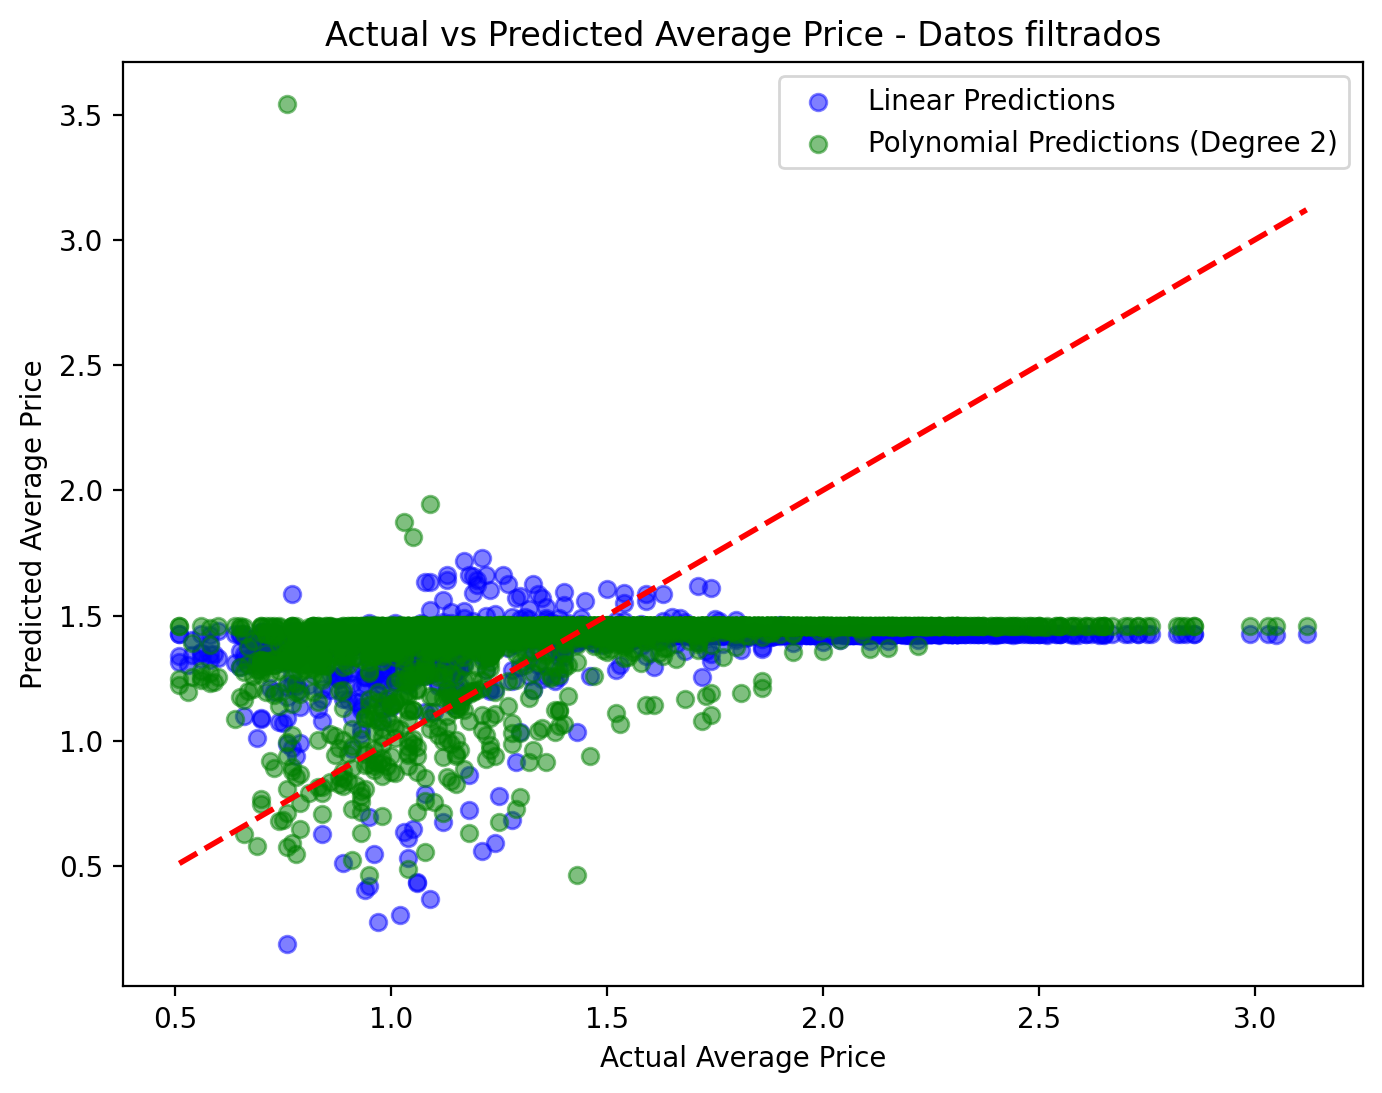

In [ ]:
# 5.8 Modelos de Regresión para Diferenciar Volúmenes de Ventas
"""
Modelos de Regresión para Diferenciar Volúmenes de Ventas:

Uso de Datos: Usa AveragePrice, Total Volume, 4046, 4225, y 4770.
Esperado:
Ajusta modelos de regresión para analizar cómo los diferentes volúmenes de ventas afectan AveragePrice.
Compara los resultados de regresión lineal y polinómica.
Presenta las conclusiones de tus análisis.
"""
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# List of dataframes to loop through
dataframes = [df]
titles = ["Datos filtrados"]

# Define the features and target
features = ['Total Volume', '4046', '4225', '4770']
target = 'AveragePrice'

# Degree of polynomial for polynomial regression
poly_degree = 2

# Loop over each dataset
for idx, data in enumerate(dataframes):
    print(f"\nDataset: {titles[idx]}")

    # Define independent (X) and dependent (y) variables
    X = data[features]
    y = data[target]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Linear Regression
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    y_pred_linear = linear_model.predict(X_test)
    r2_linear = r2_score(y_test, y_pred_linear)
    rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
    print(f"Linear Regression - R²: {r2_linear:.4f}, RMSE: {rmse_linear:.4f}")

    # Polynomial Regression
    poly = PolynomialFeatures(degree=poly_degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)
    y_pred_poly = poly_model.predict(X_test_poly)
    r2_poly = r2_score(y_test, y_pred_poly)
    rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
    print(f"Polynomial Regression (Degree {poly_degree}) - R²: {r2_poly:.4f}, RMSE: {rmse_poly:.4f}")

    # Comparison Plot: Linear vs Polynomial Regression
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_linear, label="Linear Predictions", alpha=0.5, color="blue")
    plt.scatter(y_test, y_pred_poly, label=f"Polynomial Predictions (Degree {poly_degree})", alpha=0.5, color="green")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Perfect prediction line
    plt.title(f"Actual vs Predicted Average Price - {titles[idx]}")
    plt.xlabel("Actual Average Price")
    plt.ylabel("Predicted Average Price")
    plt.legend()
    plt.show()

# **VERSION 2**

Regresión Lineal - MSE: 0.1542487386401943 R^2: 0.03996005046475659
Regresión Polinómica - MSE: 0.15589836201855262 R^2: 0.029692839472480803


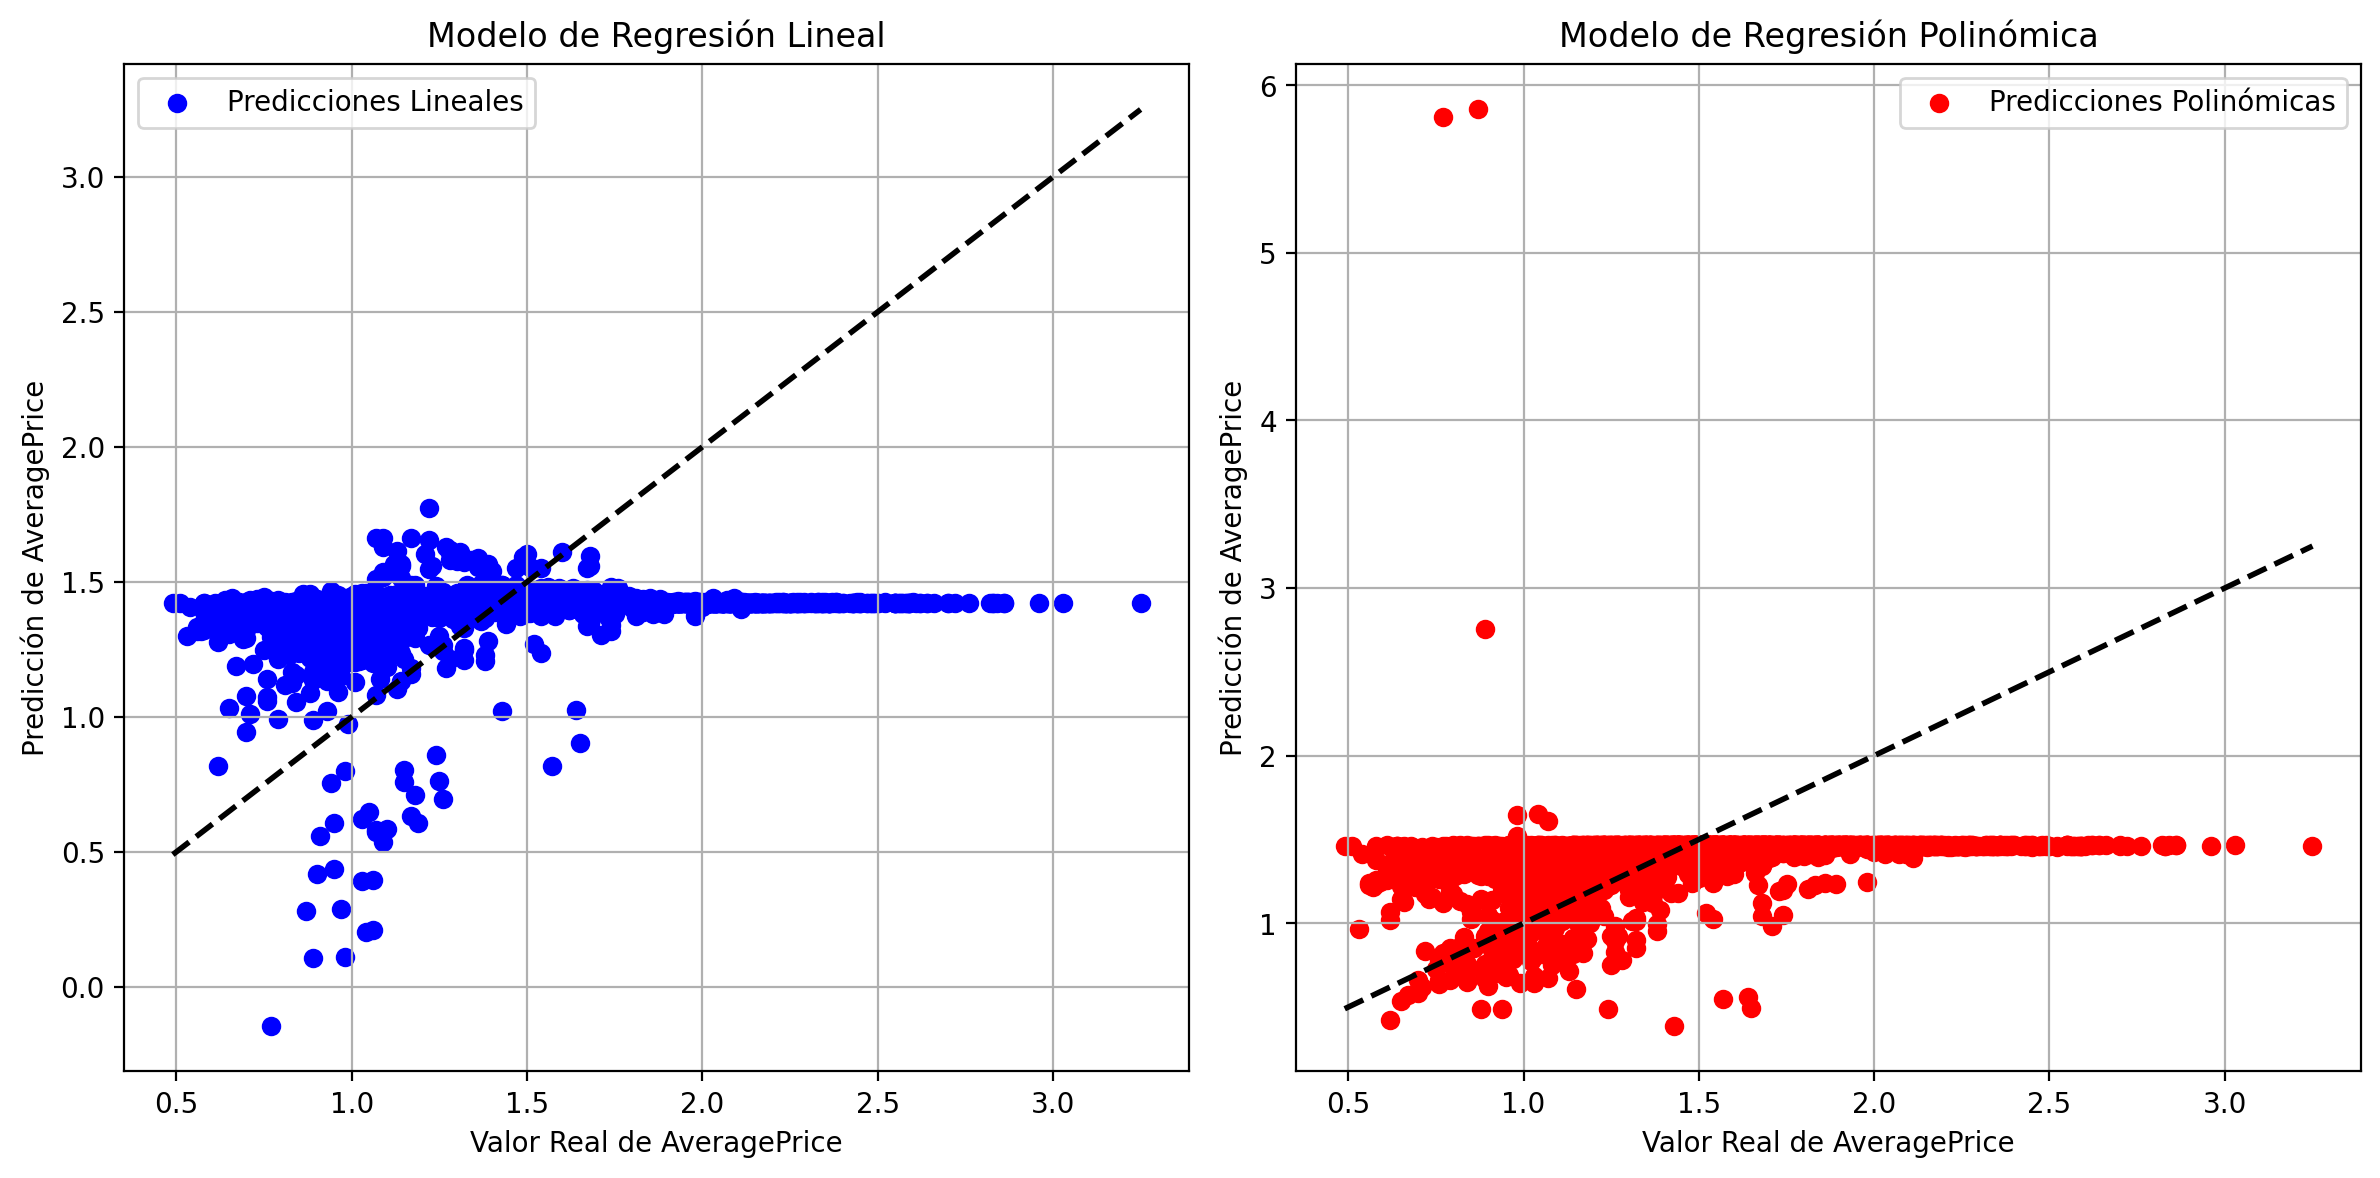

El modelo de regresión lineal tiene un menor MSE y parece ajustar mejor los datos en términos de error cuadrático.
El modelo de regresión lineal tiene un R^2 mayor, indicando que explica mejor la variabilidad en los datos.


In [ ]:
#Ajuste por tamaño

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# Cargo el dataset
df = pd.read_csv('/content/CSV/avocado.csv')

# Selecciono columnas de interés
data = df[['AveragePrice', 'Total Volume', '4046', '4225', '4770']]

# Divido en variables dependientes e independientes
X = data[['Total Volume', '4046', '4225', '4770']]
y = data['AveragePrice']

# Separo los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo de Regresión Lineal
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# Calculo MSE y R^2 para el modelo de regresión lineal
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# Modelo de Regresión Polinómica
polynomial_features = PolynomialFeatures(degree=2)
X_train_poly = polynomial_features.fit_transform(X_train)
X_test_poly = polynomial_features.transform(X_test)

# Ajusto el modelo de regresión polinómica
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
y_pred_poly = poly_model.predict(X_test_poly)

# Calculo MSE y R^2 para el modelo de regresión polinómica
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

# Comparo resultados y generar conclusiones
print("Regresión Lineal - MSE:", mse_linear, "R^2:", r2_linear)
print("Regresión Polinómica - MSE:", mse_poly, "R^2:", r2_poly)

plt.figure(figsize=(12, 6))

# Gráfico de dispersión de precios promedio vs predicciones lineales
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_linear, color='blue', label='Predicciones Lineales')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Valor Real de AveragePrice")
plt.ylabel("Predicción de AveragePrice")
plt.title("Modelo de Regresión Lineal")
plt.legend()
plt.grid(True)

# Gráfico de dispersión de precios promedio vs predicciones polinómicas
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_poly, color='red', label='Predicciones Polinómicas')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Valor Real de AveragePrice")
plt.ylabel("Predicción de AveragePrice")
plt.title("Modelo de Regresión Polinómica")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Conclusiones basadas en los resultados de MSE y R^2
if mse_linear < mse_poly:
    print("El modelo de regresión lineal tiene un menor MSE y parece ajustar mejor los datos en términos de error cuadrático.")
else:
    print("El modelo de regresión polinómica tiene un menor MSE y parece ajustar mejor los datos en términos de error cuadrático.")

if r2_linear > r2_poly:
    print("El modelo de regresión lineal tiene un R^2 mayor, indicando que explica mejor la variabilidad en los datos.")
else:
    print("El modelo de regresión polinómica tiene un R^2 mayor, indicando que explica mejor la variabilidad en los datos.")

El modelo de regresión lineal tiene un menor MSE y parece ajustar mejor los datos en términos de error cuadrático.

El modelo de regresión lineal tiene un R^2 mayor, indicando que explica mejor la variabilidad en los datos.

# 5.9.Análisis de la Influencia de las Ventas Totales en el Precio Promedio

In [ ]:
"""
Análisis de la Influencia de las Ventas Totales en el Precio Promedio:

Uso de Datos: Usa Total Volume, AveragePrice, y Total Bags.
Esperado:
Ajusta un modelo de regresión lineal y polinómica para ver cómo varía AveragePrice en función del volumen total de ventas.
Evalúa la significancia de los coeficientes y discute su relevancia.
"""
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# List of dataframes to loop through
dataframes = [df_reduced, df_cities, df_regions]
titles = ["Reduced Data", "Cities Data", "Regions Data"]

# Define the features and target
features = ['Total Volume', 'Total Bags']
target = 'AveragePrice'

# Degree of polynomial for polynomial regression
poly_degree = 2

# Loop over each dataset
for idx, data in enumerate(dataframes):
    print(f"\nDataset: {titles[idx]}")

    # Define independent (X) and dependent (y) variables
    X = data[features]
    y = data[target]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Linear Regression
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    y_pred_linear = linear_model.predict(X_test)
    r2_linear = r2_score(y_test, y_pred_linear)
    rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))

    # Print Linear Model Coefficients
    print("Linear Regression Coefficients:")
    for feature, coef in zip(features, linear_model.coef_):
        print(f"{feature}: {coef:.4f}")
    print(f"Intercept: {linear_model.intercept_:.4f}")
    print(f"Linear Regression - R²: {r2_linear:.4f}, RMSE: {rmse_linear:.4f}")

    # Polynomial Regression
    poly = PolynomialFeatures(degree=poly_degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)
    y_pred_poly = poly_model.predict(X_test_poly)
    r2_poly = r2_score(y_test, y_pred_poly)
    rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))

    print(f"Polynomial Regression (Degree {poly_degree}) - R²: {r2_poly:.4f}, RMSE: {rmse_poly:.4f}")

    # Comparison Plot: Linear vs Polynomial Regression
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_linear, label="Linear Predictions", alpha=0.5, color="blue")
    plt.scatter(y_test, y_pred_poly, label=f"Polynomial Predictions (Degree {poly_degree})", alpha=0.5, color="green")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Perfect prediction line
    plt.title(f"Actual vs Predicted Average Price - {titles[idx]}")
    plt.xlabel("Actual Average Price")
    plt.ylabel("Predicted Average Price")
    plt.legend()
    plt.show()

# **2a VERSION**

In [ ]:
df_apt9=greater_regions[['Total Volume','AveragePrice','Total Bags', 'type']]
df_apt9=df_apt9[df_apt9['type']=='conventional'] #lo miro para el convencional
df_apt9=df_apt9.copy()

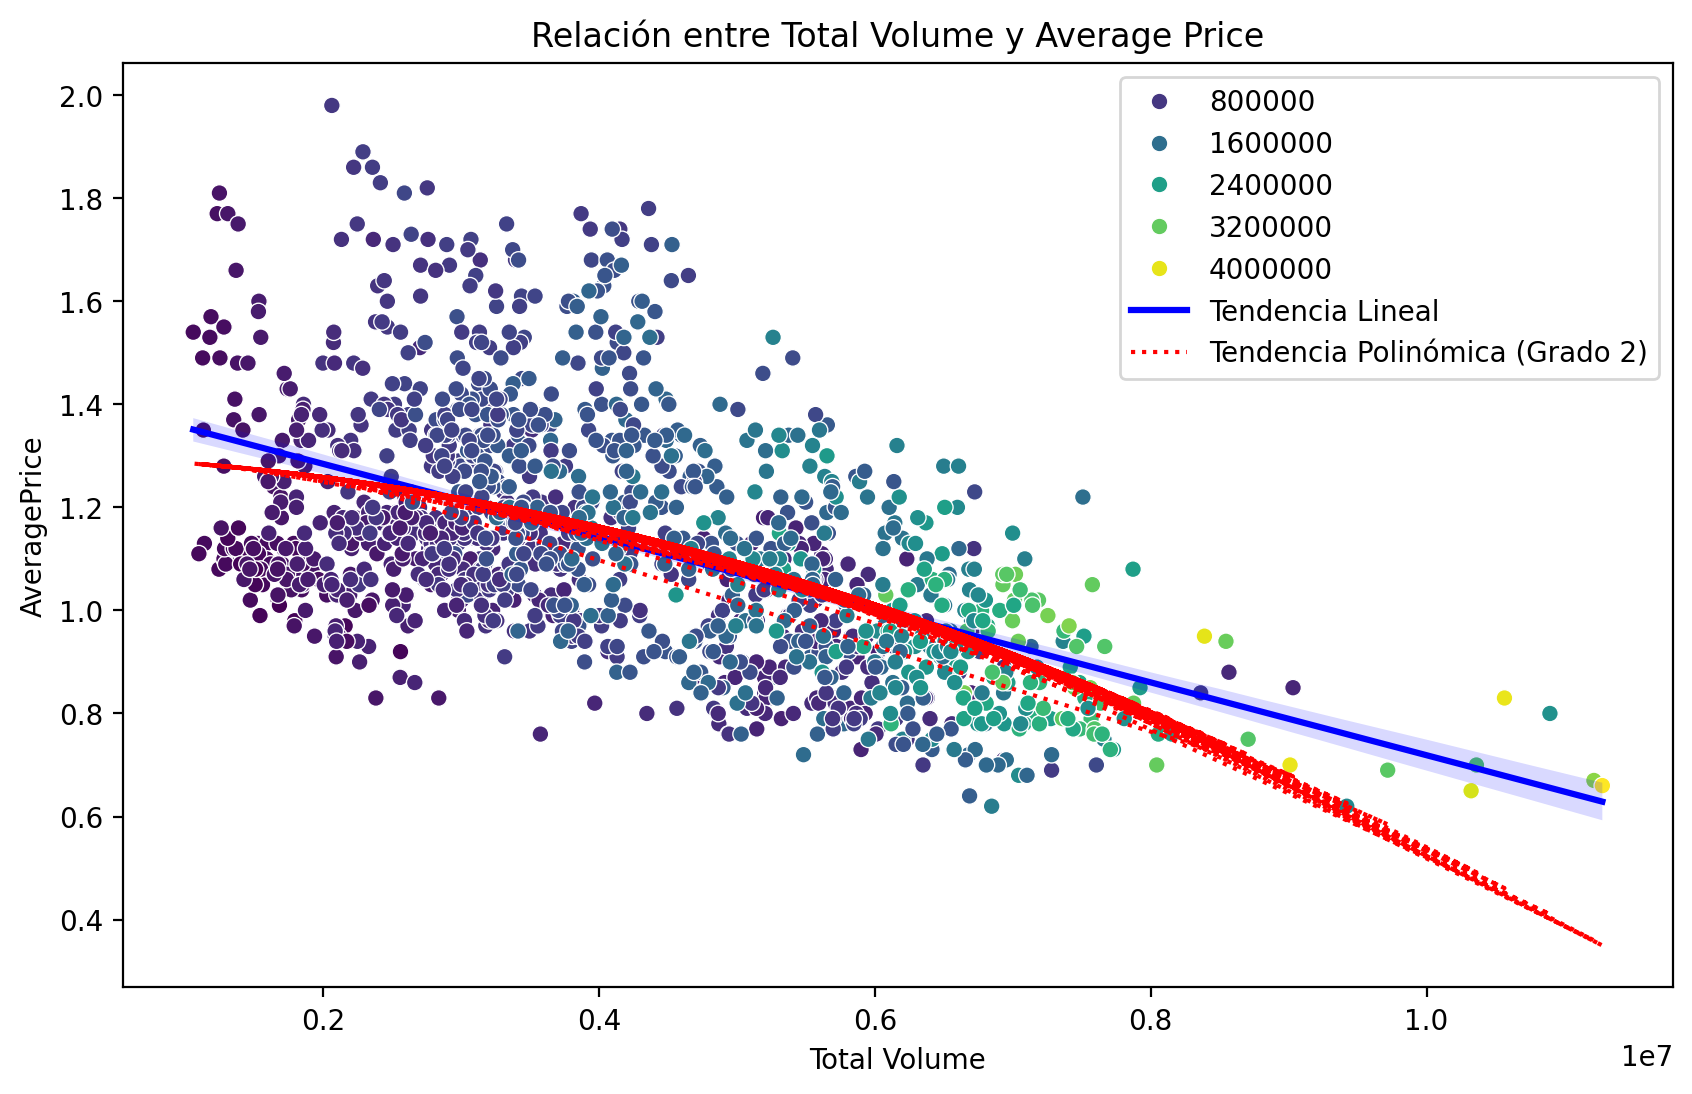

In [ ]:
#scatter plot para ver relacion entre total volume, total bags y averageprice. solo con conventional

# Visualización de la relación lineal entre 'Total Volume' y 'AveragePrice'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_apt9, x='Total Volume', y='AveragePrice', hue='Total Bags', palette='viridis')
plt.title("Relación entre Total Volume y Average Price")
plt.xlabel("Total Volume")
plt.ylabel("Average Price")

# Ajustar una línea de tendencia lineal
sns.regplot(data=df_apt9, x='Total Volume', y='AveragePrice', scatter=False, color='blue', label="Tendencia Lineal")

# Ajuste polinómico de segundo grado
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(df_apt9[['Total Volume']])
poly_model = LinearRegression().fit(X_poly, df_apt9['AveragePrice'])
df_apt9['Pred_Poly'] = poly_model.predict(X_poly)

# Graficar la línea de tendencia polinómica
plt.plot(df_apt9['Total Volume'], df_apt9['Pred_Poly'], color='red', linestyle='dotted', label="Tendencia Polinómica (Grado 2)")

# Mostrar leyenda
plt.legend()
plt.show()

In [ ]:
#Vamos a definir las variables
X=df_apt9[['Total Volume','Total Bags']]
y=df_apt9['AveragePrice']

# Función para entrenar modelos y hacer predicciones
def train_and_evaluate_models(X, y):
    # Modelo Lineal
    linear_model = LinearRegression()
    linear_model.fit(X, y)
    y_pred_linear = linear_model.predict(X)

    # Extraer coeficientes e intercepto del modelo lineal
    pesos_lineal = linear_model.coef_
    intercept_lineal = linear_model.intercept_

    # Modelo Polinómico (grados 2)
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y)
    y_pred_poly = poly_model.predict(X_poly)

    # Extraer coeficientes e intercepto del modelo polinomial
    pesos_poly = poly_model.coef_
    intercept_poly = poly_model.intercept_

    # Guardamos las características generadas
    feature_names = poly.get_feature_names_out(X.columns)

    return y_pred_linear, y_pred_poly, pesos_lineal, pesos_poly, intercept_lineal, intercept_poly, feature_names

# Ajustar y evaluar para AveragePrice
y_pred_linear, y_pred_poly, pesos_lineal, pesos_poly, intercept_lineal, intercept_poly, feature_names = train_and_evaluate_models(X, y)

In [ ]:
# Evaluar AveragePrice
print("Evaluación para AveragePrice con modelo de Regresión Lineal 'Aguacate CONVENIONAL'")
print("\nMSE:", mean_squared_error(y, y_pred_linear))
print("R^2:", r2_score(y, y_pred_linear))

print("\nEvaluación para AveragePrice con modelo de Regresión Polinómica 'Aguacate CONVENTIONAL'")
print("\nMSE:", mean_squared_error(y, y_pred_poly))
print("R^2:", r2_score(y, y_pred_poly))

Evaluación para AveragePrice con modelo de Regresión Lineal 'Aguacate CONVENIONAL'

MSE: 0.0368294470890018
R^2: 0.32424884891063155

Evaluación para AveragePrice con modelo de Regresión Polinómica 'Aguacate CONVENTIONAL'

MSE: 0.0330260875609311
R^2: 0.39403334969038917


In [ ]:
#extraemos pesos de los modelos
print('Modelos lineal:\n')
print('Pesos',pesos_lineal)
print('Intercept:',intercept_lineal)

print('\nModelo Polinómico:\n')
print('Pesos',pesos_poly)
print('Intercept:',intercept_poly)

Modelos lineal:

Pesos [-1.01630318e-07  1.07354062e-07]
Intercept: 1.4329773357227795

Modelo Polinómico:

Pesos [ 0.00000000e+00 -1.74270669e-07  5.78783056e-07  1.37693937e-14
 -6.05429364e-14 -3.10998269e-14]
Intercept: 1.3126372411911285


In [ ]:
# Mostrar los coeficientes generados por el polinómico con sus nombres
pd.DataFrame({'Feature': feature_names, 'Coefficient': pesos_poly})

Feature   Coefficient
0                        1  0.000000e+00
1             Total Volume -1.742707e-07
2               Total Bags  5.787831e-07
3           Total Volume^2  1.376939e-14
4  Total Volume Total Bags -6.054294e-14
5             Total Bags^2 -3.109983e-14

Interpretación:

El coeficiente del TOTAL VOLUME es poco significativo y negativo, podría implicar que mayores ventas están vinculadas a una disminución en el precio promedio pero de forma leve.

# 5.10. Regresión para Predecir el Precio Promedio Según el Volumen de Aguacates por Tipo


Dataset: Datos filtrados
Linear Regression - R²: 0.0400, RMSE: 0.3927
Polynomial Regression (Degree 2) - R²: 0.0297, RMSE: 0.3948


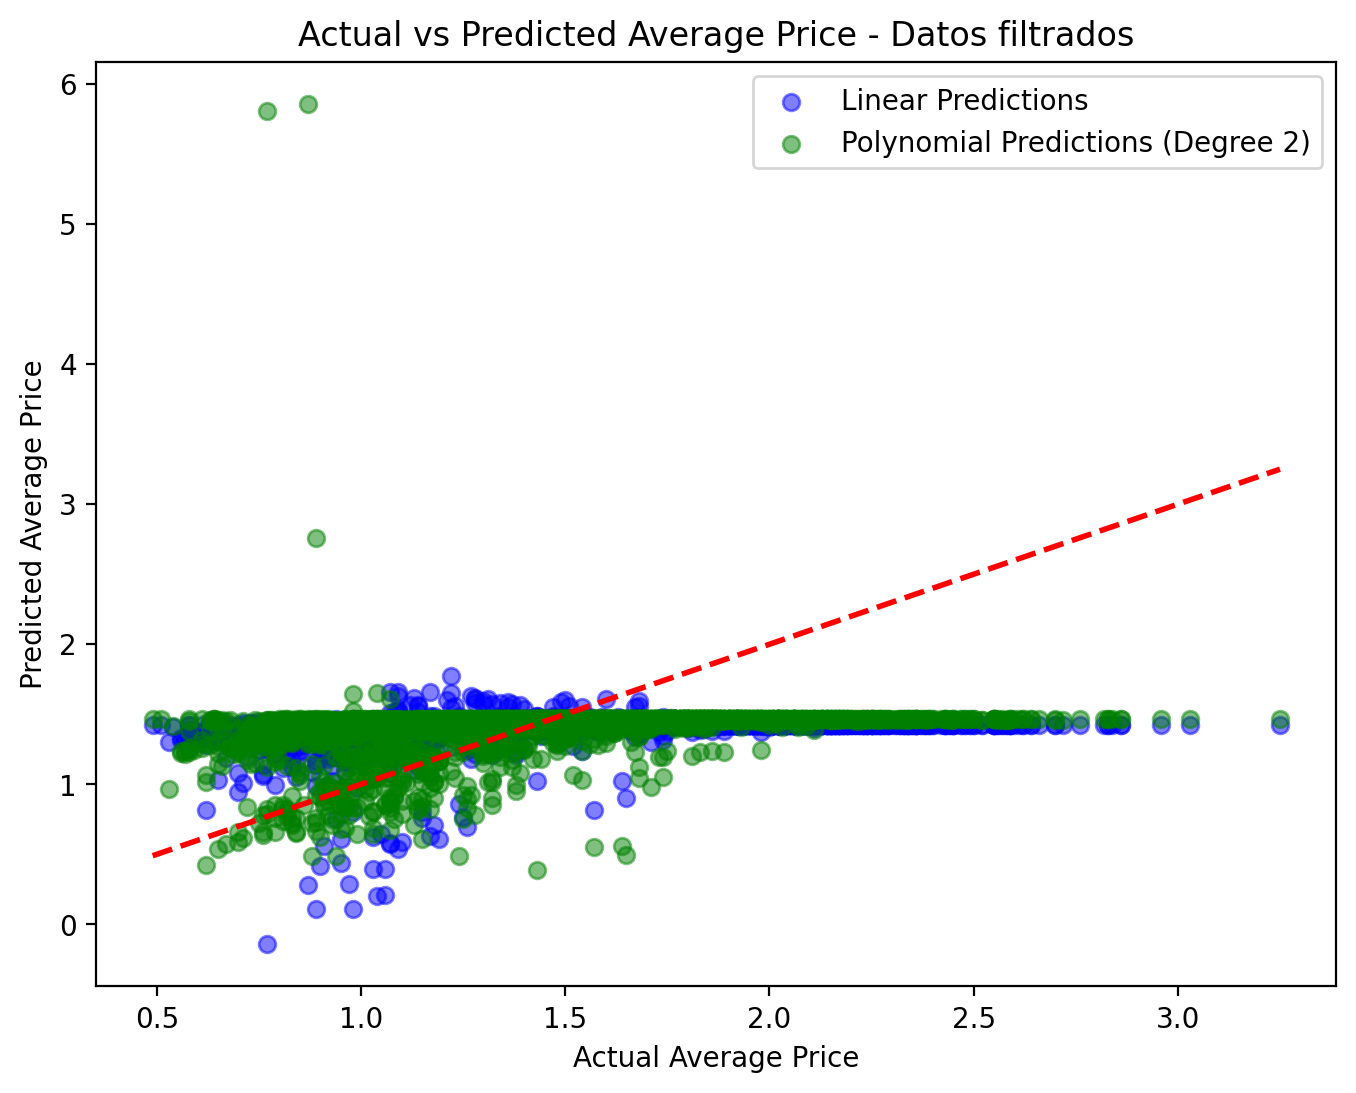

In [ ]:
"""
Regresión para Predecir el Precio Promedio Según el Volumen de Aguacates por Tipo:

Uso de Datos: Usa AveragePrice, 4046, 4225, 4770, y Total Volume.
Esperado:
Ajusta modelos de regresión lineal y polinómica.
Evalúa la efectividad de ambos modelos utilizando métricas como R² y RMSE.
Discute cuál modelo ofrece mejores predicciones y por qué, basándote en los resultados obtenidos.
"""
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# List of dataframes to loop through
dataframes = [df]
titles = ["Datos filtrados"]

# Define the features and target
features = ['4046', '4225', '4770', 'Total Volume']
target = 'AveragePrice'

# Degree of polynomial for polynomial regression
poly_degree = 2

# Loop over each dataset
for idx, data in enumerate(dataframes):
    print(f"\nDataset: {titles[idx]}")

    # Define independent (X) and dependent (y) variables
    X = data[features]
    y = data[target]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Linear Regression
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    y_pred_linear = linear_model.predict(X_test)
    r2_linear = r2_score(y_test, y_pred_linear)
    rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
    print(f"Linear Regression - R²: {r2_linear:.4f}, RMSE: {rmse_linear:.4f}")

    # Polynomial Regression
    poly = PolynomialFeatures(degree=poly_degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)
    y_pred_poly = poly_model.predict(X_test_poly)
    r2_poly = r2_score(y_test, y_pred_poly)
    rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
    print(f"Polynomial Regression (Degree {poly_degree}) - R²: {r2_poly:.4f}, RMSE: {rmse_poly:.4f}")

    # Comparison Plot: Linear vs Polynomial Regression
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_linear, label="Linear Predictions", alpha=0.5, color="blue")
    plt.scatter(y_test, y_pred_poly, label=f"Polynomial Predictions (Degree {poly_degree})", alpha=0.5, color="green")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Perfect prediction line
    plt.title(f"Actual vs Predicted Average Price - {titles[idx]}")
    plt.xlabel("Actual Average Price")
    plt.ylabel("Predicted Average Price")
    plt.legend()
    plt.show()

# **Version 1.2**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Polynomial degree (can adjust based on performance)
poly_degree = 2

# Initialize models
linear_model = LinearRegression()
poly = PolynomialFeatures(degree=poly_degree)
poly_model = LinearRegression()

# Datasets to evaluate
dataframes = [df]
titles = ["Datos filtrados"]

# Features and target
features = ['4046', '4225', '4770', 'Total Volume']
target = 'AveragePrice'

# Initialize list to store results
results = []

# Loop over each dataset
for idx, data in enumerate(dataframes):
    print(f"\nDataset: {titles[idx]}")

    # Define X and y
    X = data[features]
    y = data[target]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Linear Regression
    linear_model.fit(X_train, y_train)
    y_train_pred_linear = linear_model.predict(X_train)
    y_test_pred_linear = linear_model.predict(X_test)

    # Calculate metrics for Linear Regression
    r2_train_linear = r2_score(y_train, y_train_pred_linear)
    r2_test_linear = r2_score(y_test, y_test_pred_linear)
    mse_train_linear = mean_squared_error(y_train, y_train_pred_linear)
    mse_test_linear = mean_squared_error(y_test, y_test_pred_linear)
    rmse_train_linear = np.sqrt(mse_train_linear)
    rmse_test_linear = np.sqrt(mse_test_linear)

    # Store results for linear model
    results.append({
        "Dataset": titles[idx],
        "Model": "Linear",
        "R² Train": r2_train_linear,
        "R² Test": r2_test_linear,
        "R² Gap": abs(r2_train_linear - r2_test_linear),
        "RMSE Train": rmse_train_linear,
        "RMSE Test": rmse_test_linear,
        "RMSE Gap": abs(rmse_train_linear - rmse_test_linear)
    })

    # Polynomial Regression
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    poly_model.fit(X_train_poly, y_train)
    y_train_pred_poly = poly_model.predict(X_train_poly)
    y_test_pred_poly = poly_model.predict(X_test_poly)

    # Calculate metrics for Polynomial Regression
    r2_train_poly = r2_score(y_train, y_train_pred_poly)
    r2_test_poly = r2_score(y_test, y_test_pred_poly)
    mse_train_poly = mean_squared_error(y_train, y_train_pred_poly)
    mse_test_poly = mean_squared_error(y_test, y_test_pred_poly)
    rmse_train_poly = np.sqrt(mse_train_poly)
    rmse_test_poly = np.sqrt(mse_test_poly)

    # Store results for polynomial model
    results.append({
        "Dataset": titles[idx],
        "Model": f"Polynomial (Degree {poly_degree})",
        "R² Train": r2_train_poly,
        "R² Test": r2_test_poly,
        "R² Gap": abs(r2_train_poly - r2_test_poly),
        "RMSE Train": rmse_train_poly,
        "RMSE Test": rmse_test_poly,
        "RMSE Gap": abs(rmse_train_poly - rmse_test_poly)
    })

# Display results in a table for easy comparison
results_df = pd.DataFrame(results)
print("\nModel Comparison Table:")
print(results_df)


Dataset: Datos filtrados

Model Comparison Table:
           Dataset                  Model  R² Train   R² Test    R² Gap  \
0  Datos filtrados                 Linear  0.050749  0.039960  0.010789   
1  Datos filtrados  Polynomial (Degree 2)  0.126491  0.029693  0.096798   

   RMSE Train  RMSE Test  RMSE Gap  
0    0.392752   0.392745  0.000007  
1    0.376757   0.394840  0.018082  


# **VERSION 2**

In [ ]:
#Vamos a definir las variables
X=df_ej6[['4046','4225','4770','Total Volume']]
y=df_ej6['AveragePrice']

# Función para entrenar modelos y hacer predicciones
def train_and_evaluate_models(X, y):
    # Modelo Lineal
    linear_model = LinearRegression()
    linear_model.fit(X, y)
    y_pred_linear = linear_model.predict(X)

    # Extraer coeficientes e intercepto del modelo lineal
    pesos_lineal = linear_model.coef_
    intercept_lineal = linear_model.intercept_

    # Modelo Polinómico (grados 2)
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y)
    y_pred_poly = poly_model.predict(X_poly)

    # Extraer coeficientes e intercepto del modelo polinomial
    pesos_poly = poly_model.coef_
    intercept_poly = poly_model.intercept_

    # Guardamos las características generadas
    feature_names = poly.get_feature_names_out(X.columns)

    return y_pred_linear, y_pred_poly, pesos_lineal, pesos_poly, intercept_lineal, intercept_poly, feature_names

# Ajustar y evaluar para AveragePrice
y_pred_linear, y_pred_poly, pesos_lineal, pesos_poly, intercept_lineal, intercept_poly, feature_names = train_and_evaluate_models(X, y)

In [ ]:
# Evaluar AveragePrice
print("Evaluación para AveragePrice con modelo de Regresión Lineal")
print("\nMSE:", mean_squared_error(y, y_pred_linear_avg_price))
print("R^2:", r2_score(y, y_pred_linear_avg_price))

print("\nEvaluación para AveragePrice con modelo de Regresión Polinómica")
print("\nMSE:", mean_squared_error(y, y_pred_poly_avg_price))
print("R^2:", r2_score(y, y_pred_poly_avg_price))

Evaluación para AveragePrice con modelo de Regresión Lineal


ValueError: Found input variables with inconsistent numbers of samples: [2704, 2]

## **TEST**

In [ ]:
# Evaluar AveragePrice
print("Evaluación para AveragePrice con modelo de Regresión Lineal")
print("\nMSE:", mean_squared_error(y, y_pred_linear))
print("R^2:", r2_score(y, y_pred_linear))

print("\nEvaluación para AveragePrice con modelo de Regresión Polinómica")
print("\nMSE:", mean_squared_error(y, y_pred_poly))
print("R^2:", r2_score(y, y_pred_poly))

Evaluación para AveragePrice con modelo de Regresión Lineal

MSE: 0.055324312051143916
R^2: 0.5472658131833228

Evaluación para AveragePrice con modelo de Regresión Polinómica

MSE: 0.052223823367452946
R^2: 0.5726379718402168
